In [1]:
import pandas as pd
import numpy as np
from utils.conn_data import load_pickle
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from metadata.etfs import etfs_large

warnings.filterwarnings("ignore")

In [2]:
def compute_rolling_percentiles(returns_data, window=24):
    """
    Compute rolling percentiles of ETF returns relative to their past values.

    Parameters:
    - returns_data: A pandas DataFrame with ETF return data, indexed by date.
    - window: The number of past observations to include in the rolling window.

    Returns:
    - percentiles: A pandas DataFrame of the same shape as returns_data containing the rolling percentiles.
    """
    # Function to compute the percentile of the last value in the window
    def percentile_of_last(x):
        if len(x) < window:
            # If there are fewer than 'window' elements, return NaN
            return np.nan
        else:
            # Compute the percentile of the last value relative to the others
            return (np.sum(x[-1] > x[:-1]) / len(x[:-1])) * 100

    # Apply the percentile_of_last function over a rolling window for each ETF
    percentiles = returns_data.rolling(window=window + 1).apply(percentile_of_last, raw=True)

    return percentiles

In [3]:
class backtester:
    def __init__(self, dfPred):
        self.yPred = dfPred["prediction"]
        self.yTrue = dfPred["true"]
        
    def simpleStrategy(self):
        self.stratName = "simple"
        self.pnl = np.sign(self.yPred) * self.yTrue
        #self.pnl = self.pnl.reshape(-1)
        return self.pnl

def calculateRollingSharpeRatio(dfPnl, window = 3, annulaize = 12, rf = 0):
    rolling_mean = (dfPnl.rolling(window=window).mean() - rf) 
    rolling_std = dfPnl.rolling(window=window).std()

    # replace zeros with NaNs
    rolling_std = rolling_std.replace(0, np.nan)

    rolling_sr = rolling_mean / rolling_std * np.sqrt(annulaize)

    return rolling_sr

def calculateSharpeRatio(dfPnl, annulaize = 12, rf = 0):
    sr = (dfPnl.mean() - rf) / dfPnl.std() * np.sqrt(annulaize)
    return sr

def calculateExpectedReturn(dfPnl, annulaize = 12):
    cr = dfPnl.mean() * annulaize * 100
    return cr

def calculateVolatility(dfPnl, annualize = 12):
    v = dfPnl.std() * annualize * 100
    return v

def calculateSortino(dfPnl, annualize = 12):
    
    # portfolio downside vol
    downside_rets = dfPnl.copy()
    downside_rets[downside_rets >= 0] = np.nan
    downside_vol = downside_rets[~pd.isna(downside_rets)].std()

    # portfolio sharpe
    sortino_ratio = (dfPnl.mean() / downside_vol) * annualize

    return sortino_ratio

def calculateAvgDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    avg_drawdown = drawdown.mean() * 100

    return avg_drawdown

def calculateMaxDD(dfPnl):
    
    # cummualitive portfolio pnl
    cummulative_portfolio_returns = np.exp(dfPnl.cumsum())

    # rolling max value
    rolling_max = cummulative_portfolio_returns.cummax()

    # ensure the drawdown is zero for the first element
    rolling_max.loc[0, :] = 1.0

    # drawdown
    drawdown = (cummulative_portfolio_returns - rolling_max) / rolling_max

    # max. drawdown
    max_drawdown = drawdown.min() * 100

    return max_drawdown

In [4]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

fs_methods_tags = {
    "sfstscv-lin_nocluster": "Sequential FS",
    "sfstscv-rf_rollingkmeans_k5_rank": "Sequential FS KM5",
    "sfstscv-rf_rollingkmeans_k10_rank": "Sequential FS KM10",
    "dynotears_nocluster": "Dynotears",
    "dynotears_rollingkmeans_k5_rank": "Dynotears KM5",
    "dynotears_rollingkmeans_k10_rank": "Dynotears KM10",
    "lasso1_nocluster": "Lasso",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "multivariate-granger_nocluster": "Multivariate Granger",
    "var-lingam_rollingkmeans_k5_rank": "VAR-LiNGAM Cluster KM5",
    "var-lingam_rollingkmeans_k10_rank": "VAR-LiNGAM Cluster KM10",
}

fs_methods = [
    "sfstscv-lin_nocluster",
    "sfstscv-rf_rollingkmeans_k5_rank",
    "sfstscv-rf_rollingkmeans_k10_rank",
    # "dynotears_nocluster",
    "dynotears_rollingkmeans_k5_rank",
    "dynotears_rollingkmeans_k10_rank",
    "multivariate-granger_nocluster",
    "pairwise-granger_nocluster",
    "var-lingam_rollingkmeans_k5_rank",
    "var-lingam_rollingkmeans_k10_rank",
]

metric_funcs = {
    "E[Rt]": calculateExpectedReturn,
    "Volatility": calculateVolatility,
    "Sharpe": calculateSharpeRatio,
    "Sortino": calculateSortino,
    "AvgDD": calculateAvgDD,
    "MaxDD": calculateMaxDD,    
}

etfs_large = [
    "SPY"
]

event_dates = [
    ("GFC", ("2007-07-01", "2008-11-01")),
    ("Dow Jones Flash Crash", ("2010-03-01", "2010-07-01")),
    ("Tsunami Fukushima", ("2011-01-01", "2011-05-01")),
    ("Black Monday 2011", ("2011-06-01", "2011-10-01")),
    ("Chinese Black Monday", ("2015-06-01", "2015-10-01")),
    ("Dow Jones Plunge 2018", ("2018-01-01", "2018-05-01")),
    ("COVID-19", ("2020-01-01", "2020-05-01"))
]

threshold = 90

In [5]:
all_pnl = []
all_measures = []
for etf in etfs_large:
    for i, fs in enumerate(fs_methods):
        files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", f"{etf}*.pickle"))

        if len(files) != 1:
            raise ValueError(f"Found {len(files)} files for {etf} and {fs}.")

        for f in files:
            dfPred = load_pickle(f)["predictions"].loc["2006-01-01":]
            # dfPred = np.log(1 + dfPred / 100)
            
            # run backtest
            bt = backtester(dfPred)
            bt.simpleStrategy()

            # extract pnl
            if i == 0:
                dfPnl = dfPred[["true"]].copy()
                dfPnl.columns = [etf]
            dfPnl[fs_methods_tags[fs]] = bt.pnl
    
    # save pnl
    melt_dfPnl = dfPnl.reset_index().melt("date")
    melt_dfPnl["etf"] = etf
    all_pnl.append(melt_dfPnl)

    # calculate portfolio performance measures
    measures = []
    for tag, performance_measure in metric_funcs.items():
        measure = performance_measure(dfPnl)
        measures.append(pd.DataFrame(measure, columns=[tag]))

    # Dictionary to hold the data subsets for each event
    crisis_pnl = []

    # Loop through the event_dates list, subset the DataFrame, and store each subset in the dictionary
    for event_name, (start_date, end_date) in event_dates:
        # Subset the DataFrame within the specified date range
        subset_df = dfPnl.loc[start_date:end_date]
        # Store the subset DataFrame in the dictionary with the event name as the key
        crisis_pnl.append(subset_df)

    dfCrisisPnL = pd.concat(crisis_pnl)

    # # compute volatility
    # volatility = (dfPnl[[etf]].rolling(6).std() * np.sqrt(12) * 100)

    # # compute rolling percentiles of volatility
    # volatility_percentiles = compute_rolling_percentiles(volatility, window=24)

    # # smooth percentiles
    # volatility_percentiles_smooth = volatility_percentiles.rolling(3).mean()

    # dfCrisisPnL = volatility_percentiles_smooth[volatility_percentiles_smooth >= threshold]

    # dfCrisisPnL = pd.concat([dfCrisisPnL, dfPnl.drop(etf, axis=1)], axis=1).dropna()

    crisis_measures = []
    for tag, performance_measure in metric_funcs.items():
        crisis_measure = performance_measure(dfCrisisPnL)
        crisis_measures.append(pd.DataFrame(crisis_measure, columns=[f"{tag}_crisis"]))
    

    measures_df = pd.concat(measures, axis=1)
    melt_measures_df = measures_df.reset_index().melt("index")
    melt_measures_df["etf"] = etf

    crisis_measures_df = pd.concat(crisis_measures, axis=1)
    melt_crisis_measures_df = crisis_measures_df.reset_index().melt("index")
    melt_crisis_measures_df["etf"] = etf

    melt_measures_df = pd.concat([melt_measures_df, melt_crisis_measures_df], axis=0)

    all_measures.append(melt_measures_df)

all_measures_df = pd.concat(all_measures)
all_pnl_df = pd.concat(all_pnl)

### Plot Correlation Matrices

In [6]:
# for target in all_pnl_df["etf"].unique():
#     tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
#     tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
#     tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

#     corr = tmp_dfPnl.corr()

#     sns.heatmap(corr)
#     plt.title(target)
#     plt.show()

In [7]:
all_measures_df.pivot_table(index=["index"], columns=["variable"], values="value").round(2)

variable                 AvgDD  AvgDD_crisis  E[Rt]  E[Rt]_crisis  MaxDD  \
index                                                                      
Dynotears KM10          -21.94        -26.72   0.68        -21.62 -42.21   
Dynotears KM5           -33.03        -22.85  -1.41        -10.27 -53.36   
Multivariate Granger     -6.26         -2.59  -0.86        -11.14 -38.24   
Pairwise Granger        -23.45        -19.21   0.55         -9.22 -46.16   
SPY                      -5.13        -29.05   9.00        -23.54 -38.30   
Sequential FS           -43.03        -11.86  -5.69        -16.26 -63.46   
Sequential FS KM10      -13.46         -7.02   2.42          1.78 -39.26   
Sequential FS KM5       -19.30        -18.59   2.28         -6.77 -41.04   
VAR-LiNGAM Cluster KM10  -2.04          0.00  -0.16          0.00 -10.75   
VAR-LiNGAM Cluster KM5   -0.15          0.00   1.22          2.18  -8.56   

variable                 MaxDD_crisis  Sharpe  Sharpe_crisis  Sortino  \
index                                                                   
Dynotears KM10                 -54.78    0.04          -1.06     0.18   
Dynotears KM5                  -41.51   -0.11          -0.59    -0.39   
Multivariate Granger           -27.34   -0.08          -0.91    -0.24   
Pairwise Granger               -34.52    0.03          -0.43     0.15   
SPY                            -52.37    0.57          -1.16     2.40   
Sequential FS                  -36.27   -0.36          -0.78    -1.61   
Sequential FS KM10             -26.62    0.15           0.08     0.66   
Sequential FS KM5              -32.81    0.14          -0.32     0.62   
VAR-LiNGAM Cluster KM10          0.00   -0.04            NaN    -0.05   
VAR-LiNGAM Cluster KM5           0.00    0.29           0.99     0.36   

variable                 Sortino_crisis  Volatility  Volatility_crisis  
index                                                                   
Dynotears KM10                    -4.59       54.08              70.97  
Dynotears KM5                     -2.06       44.60              60.76  
Multivariate Granger              -2.09       38.65              42.54  
Pairwise Granger                  -1.92       55.23              73.70  
SPY                               -5.13       54.97              70.34  
Sequential FS                     -3.39       55.41              72.43  
Sequential FS KM10                 0.36       55.65              74.27  
Sequential FS KM5                 -1.38       55.66              73.98  
VAR-LiNGAM Cluster KM10             NaN       13.42               0.00  
VAR-LiNGAM Cluster KM5              NaN       14.65               7.62

In [15]:
all_measures_pivot_df = all_measures_df.pivot_table(index=["index"], columns=["variable"], values="value").round(2)

all_measures_pivot_df["diff_AvgDD"] = (all_measures_pivot_df["AvgDD"] / all_measures_pivot_df["AvgDD_crisis"] - 1) * 100
all_measures_pivot_df["diff_MaxDD"] = (all_measures_pivot_df["MaxDD"] / all_measures_pivot_df["MaxDD_crisis"] - 1) * 100
all_measures_pivot_df["diff_Sharpe"] = (all_measures_pivot_df["Sharpe"] / all_measures_pivot_df["Sharpe_crisis"] - 1) * 100
all_measures_pivot_df["diff_Sortino"] = (all_measures_pivot_df["Sortino"] / all_measures_pivot_df["Sortino_crisis"] - 1) * 100
all_measures_pivot_df["diff_E[Rt]"] = (all_measures_pivot_df["E[Rt]"] / all_measures_pivot_df["E[Rt]_crisis"] - 1) * 100

all_measures_pivot_df[[col for col in all_measures_pivot_df.columns if "diff" in col]]

variable                 diff_AvgDD  diff_MaxDD  diff_Sharpe  diff_Sortino  \
index                                                                        
Dynotears KM10           -17.889222  -22.946331  -103.773585   -103.921569   
Dynotears KM5             44.551422   28.547338   -81.355932    -81.067961   
Multivariate Granger     141.698842   39.868325   -91.208791    -88.516746   
Pairwise Granger          22.071838   33.719583  -106.976744   -107.812500   
SPY                      -82.340792  -26.866527  -149.137931   -146.783626   
Sequential FS            262.816189   74.965536   -53.846154    -52.507375   
Sequential FS KM10        91.737892   47.483095    87.500000     83.333333   
Sequential FS KM5          3.819258   25.083816  -143.750000   -144.927536   
VAR-LiNGAM Cluster KM10        -inf        -inf          NaN           NaN   
VAR-LiNGAM Cluster KM5         -inf        -inf   -70.707071           NaN   

variable                 diff_E[Rt]  
index                                
Dynotears KM10          -103.145236  
Dynotears KM5            -86.270691  
Multivariate Granger     -92.280072  
Pairwise Granger        -105.965293  
SPY                     -138.232795  
Sequential FS            -65.006150  
Sequential FS KM10        35.955056  
Sequential FS KM5       -133.677991  
VAR-LiNGAM Cluster KM10        -inf  
VAR-LiNGAM Cluster KM5   -44.036697

### Boxplot Portfolio Metrics

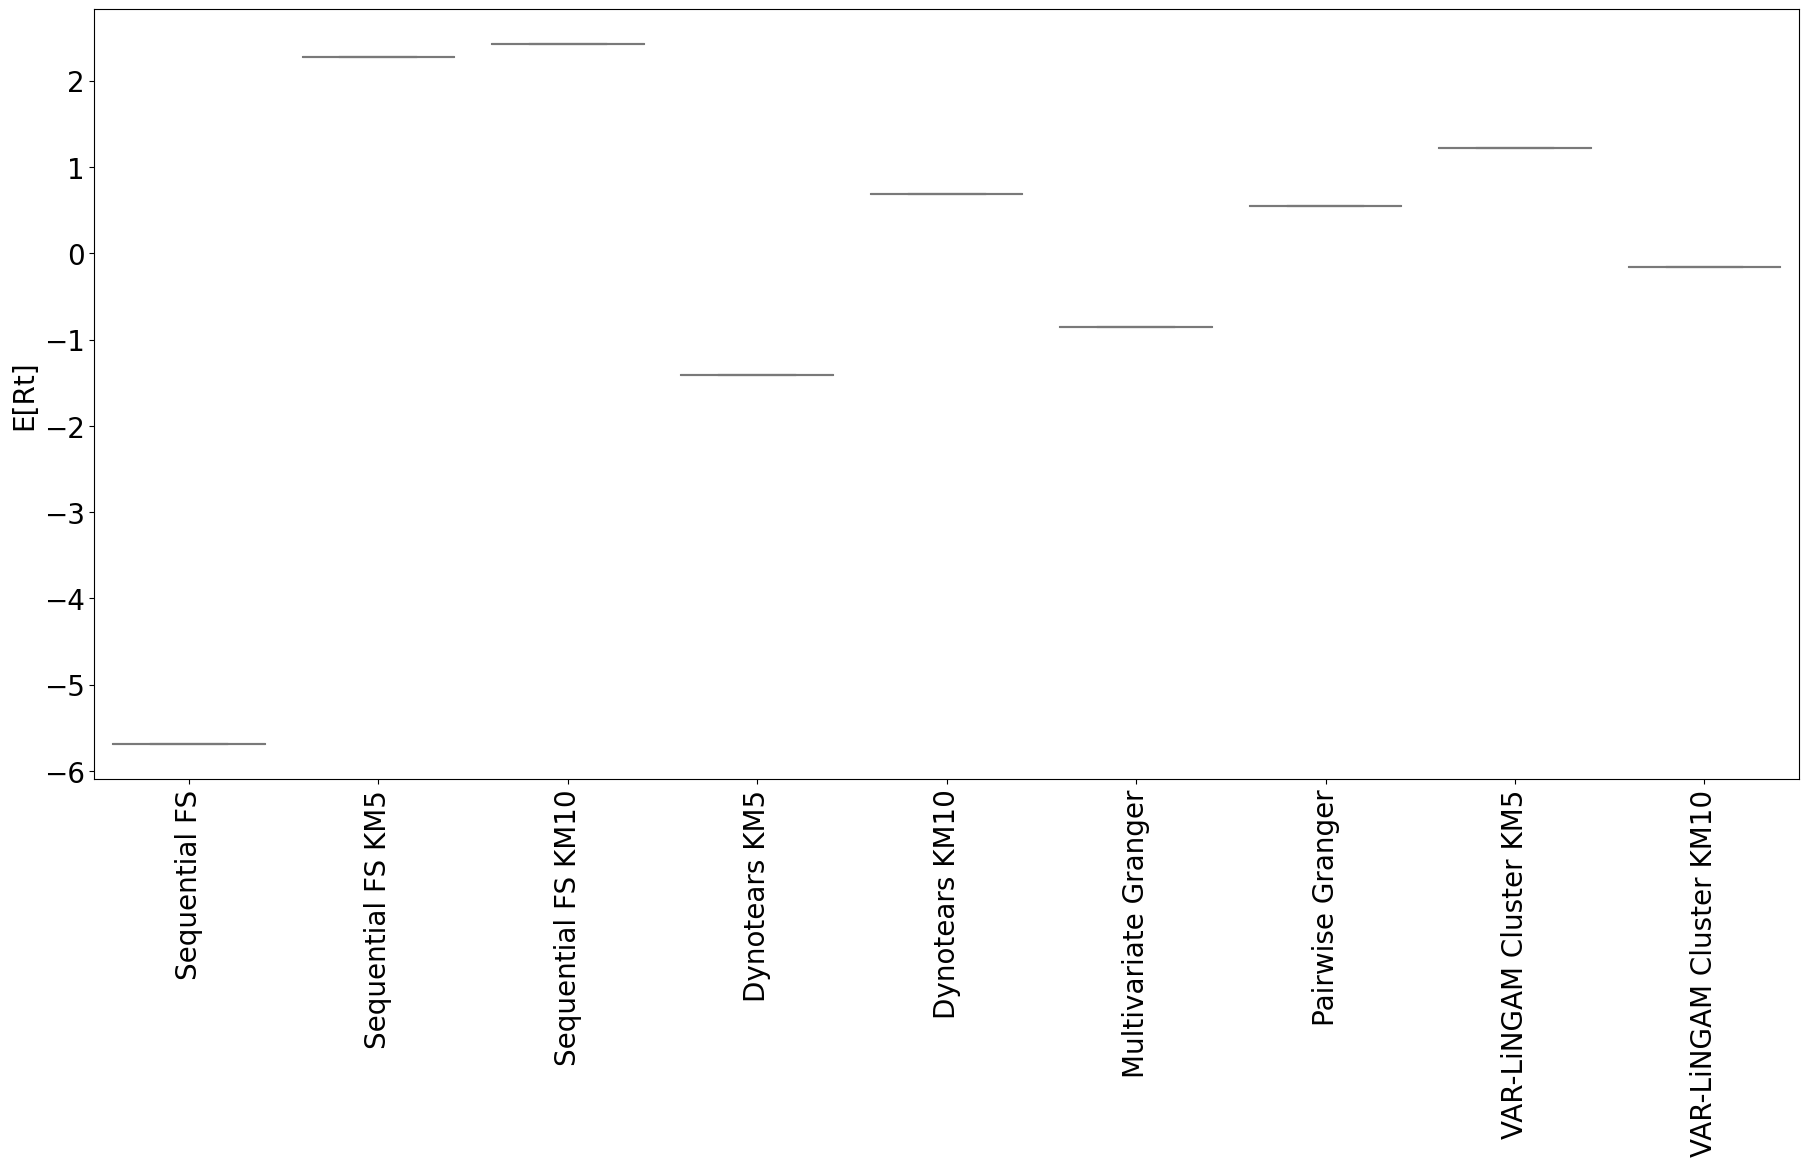

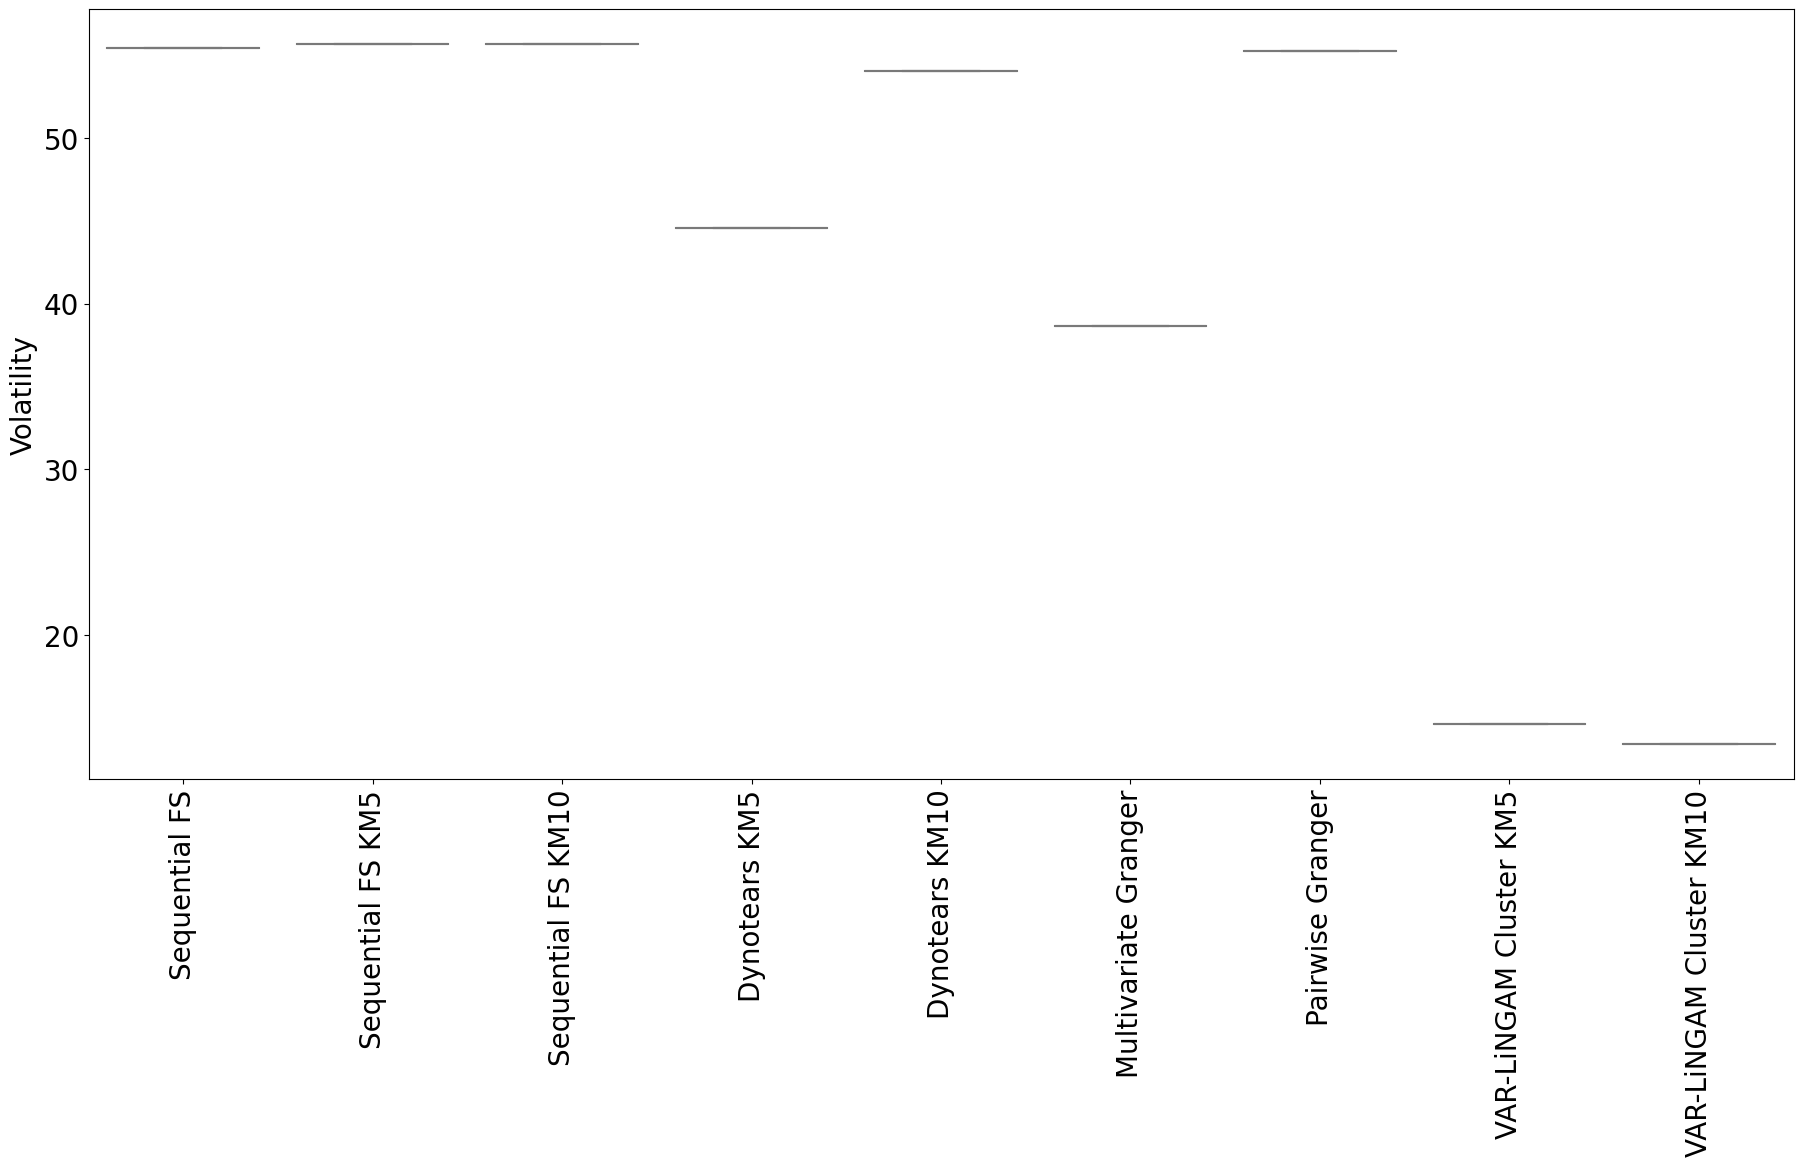

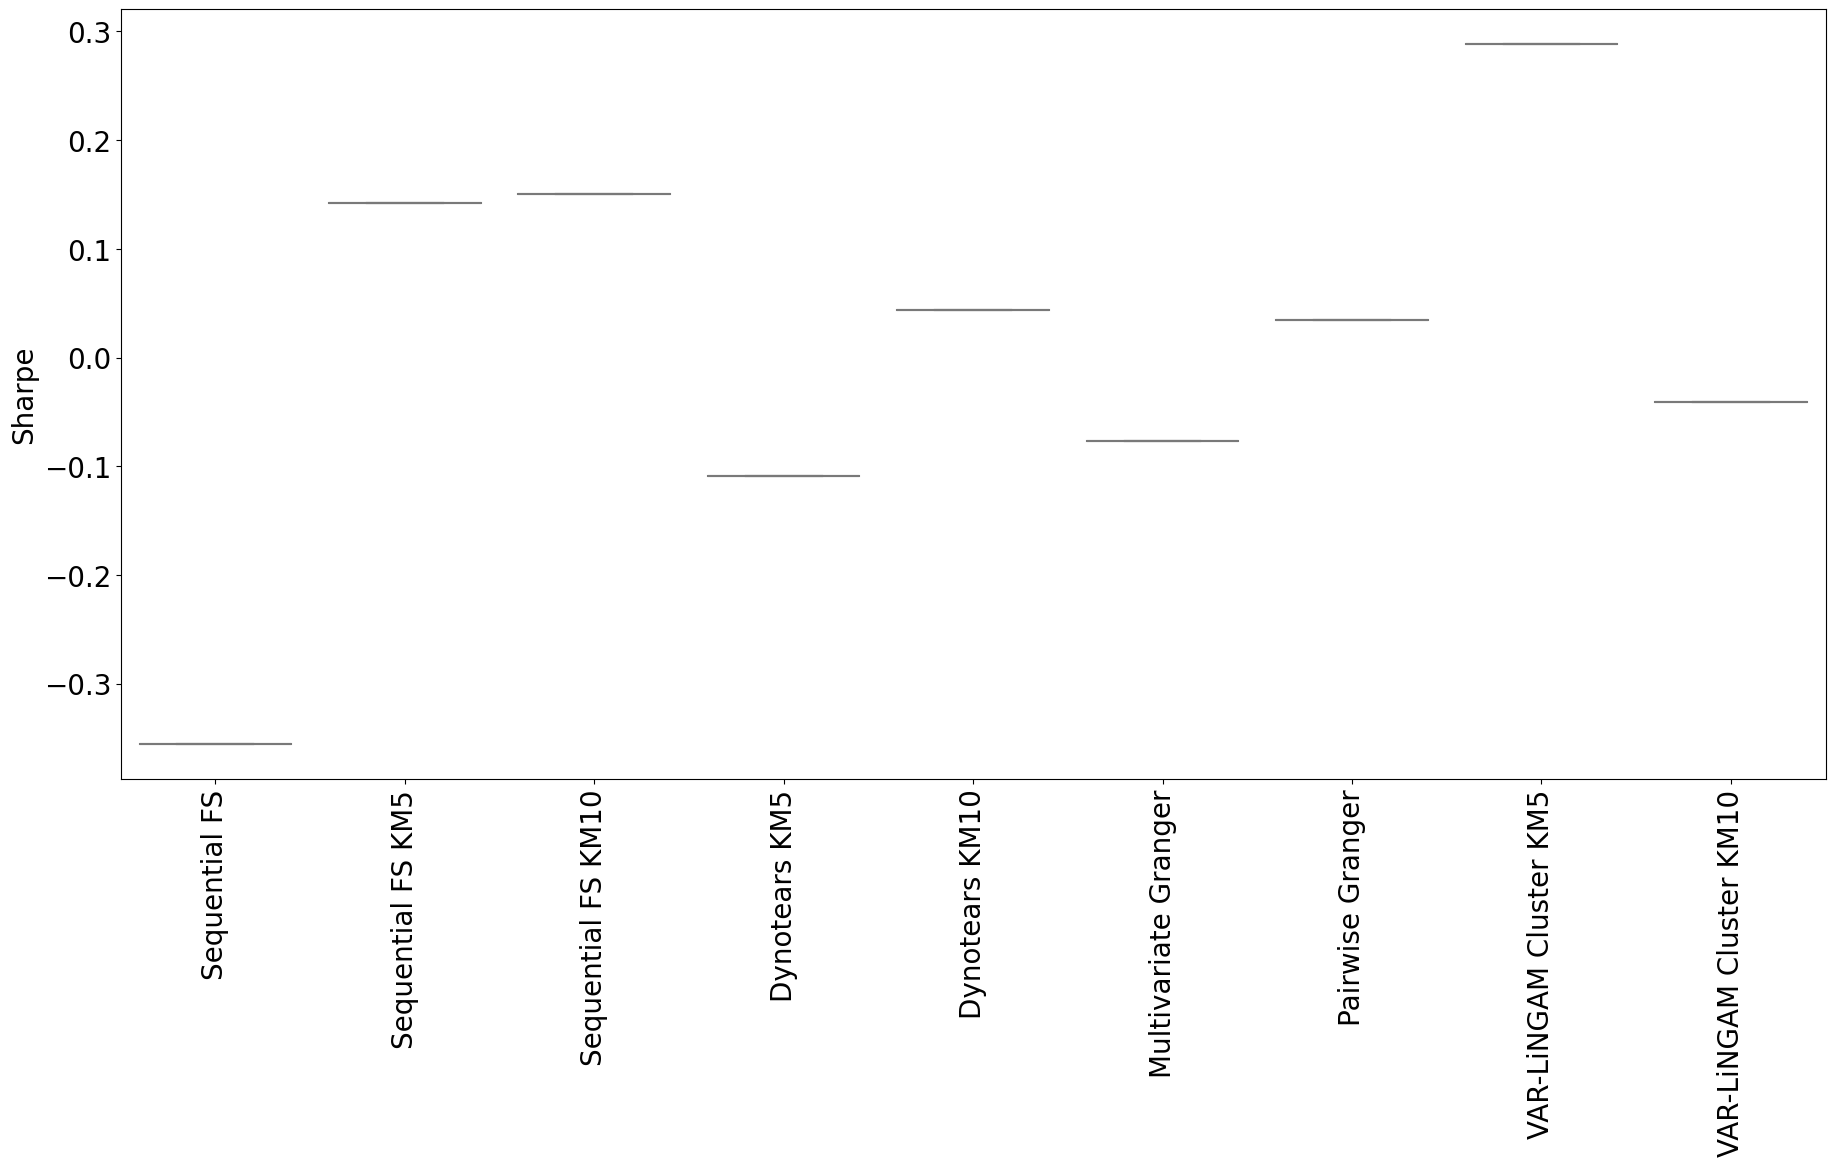

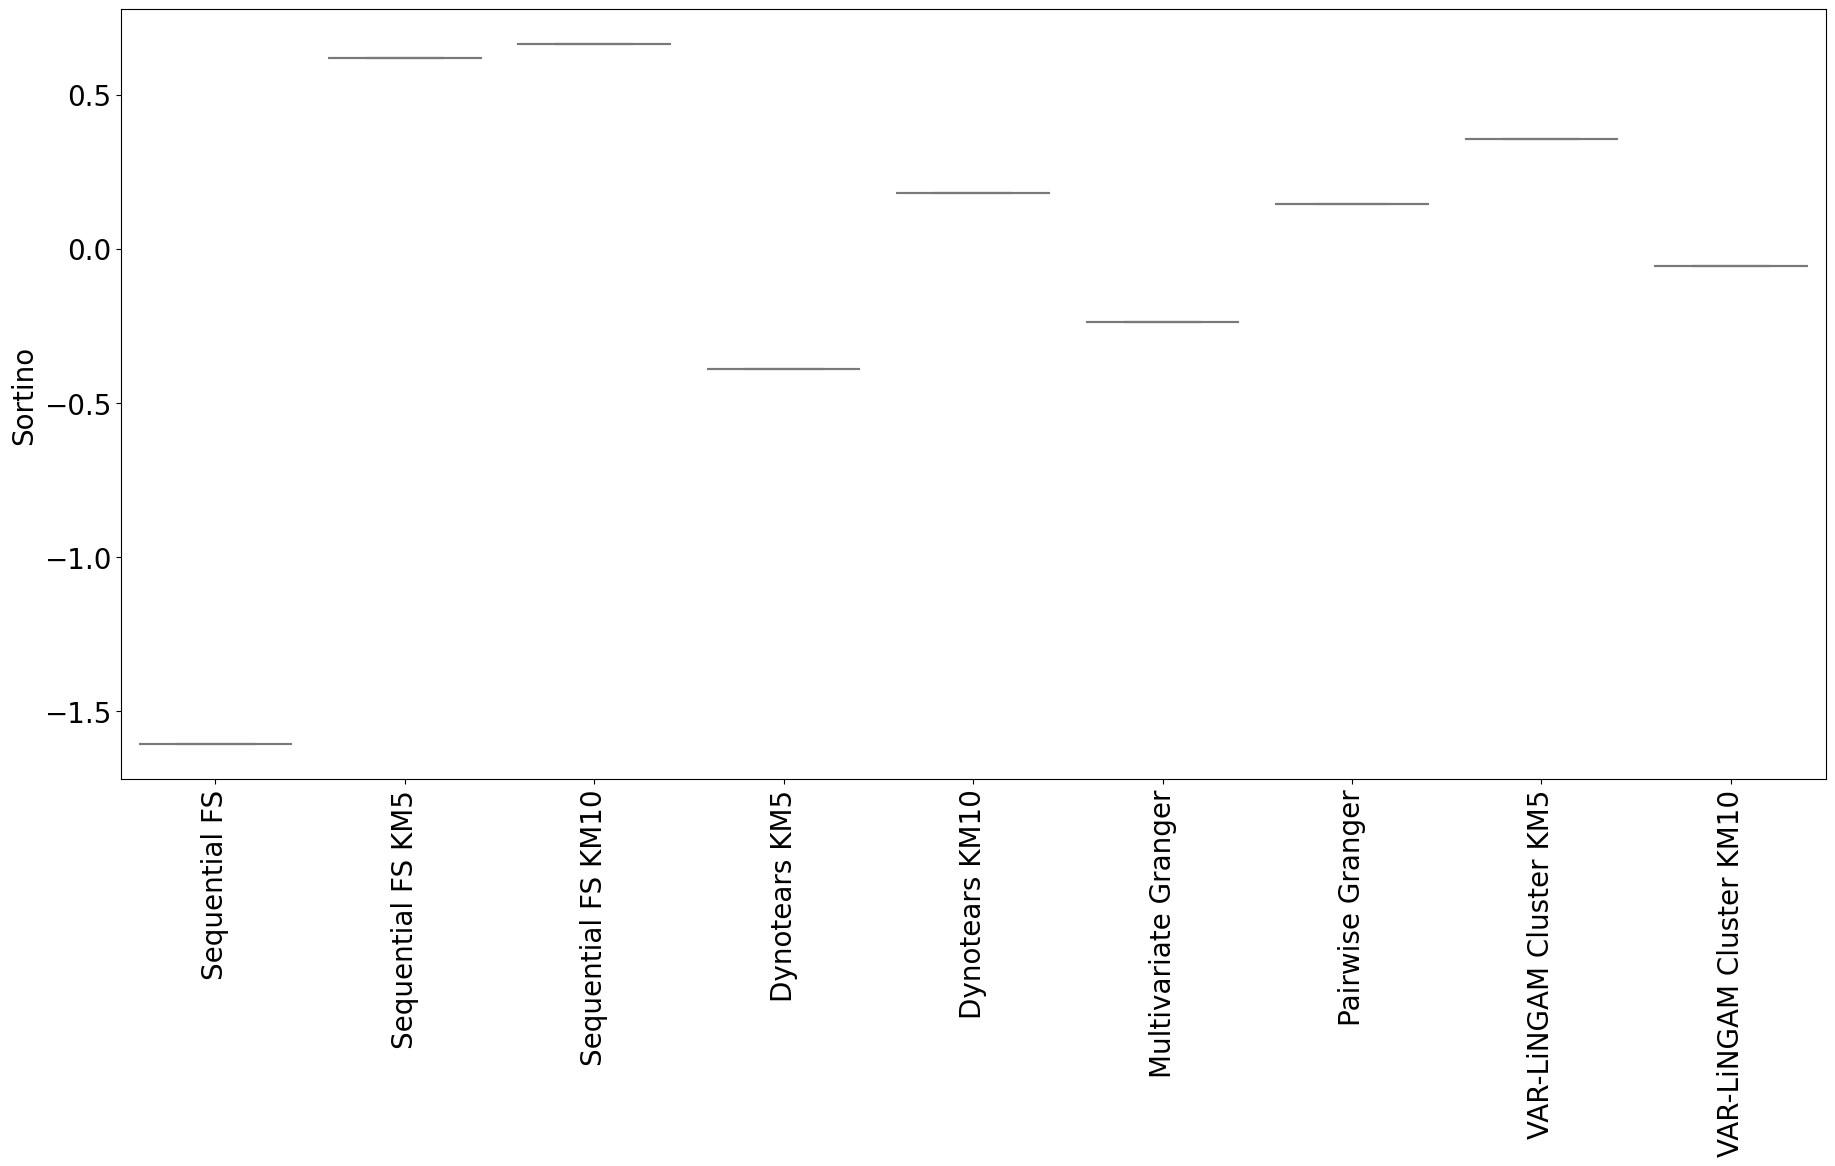

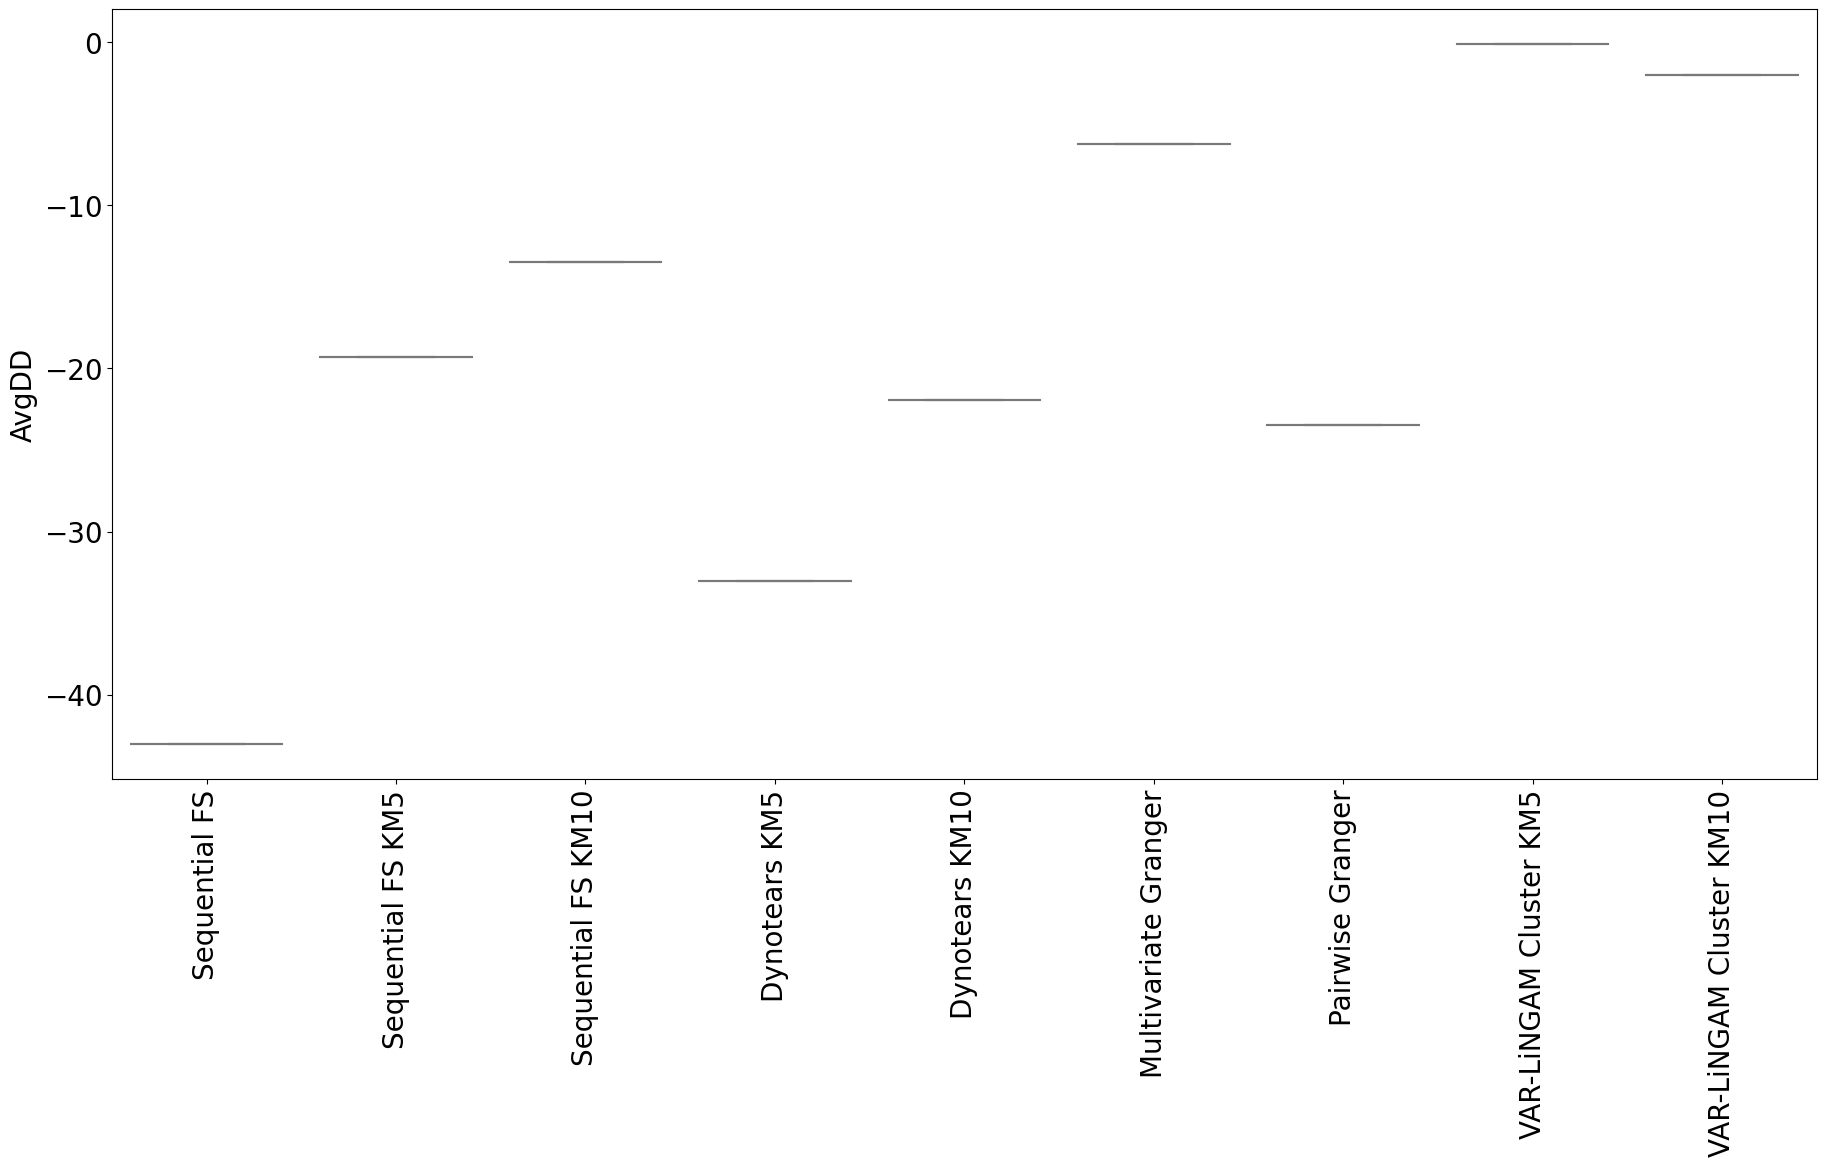

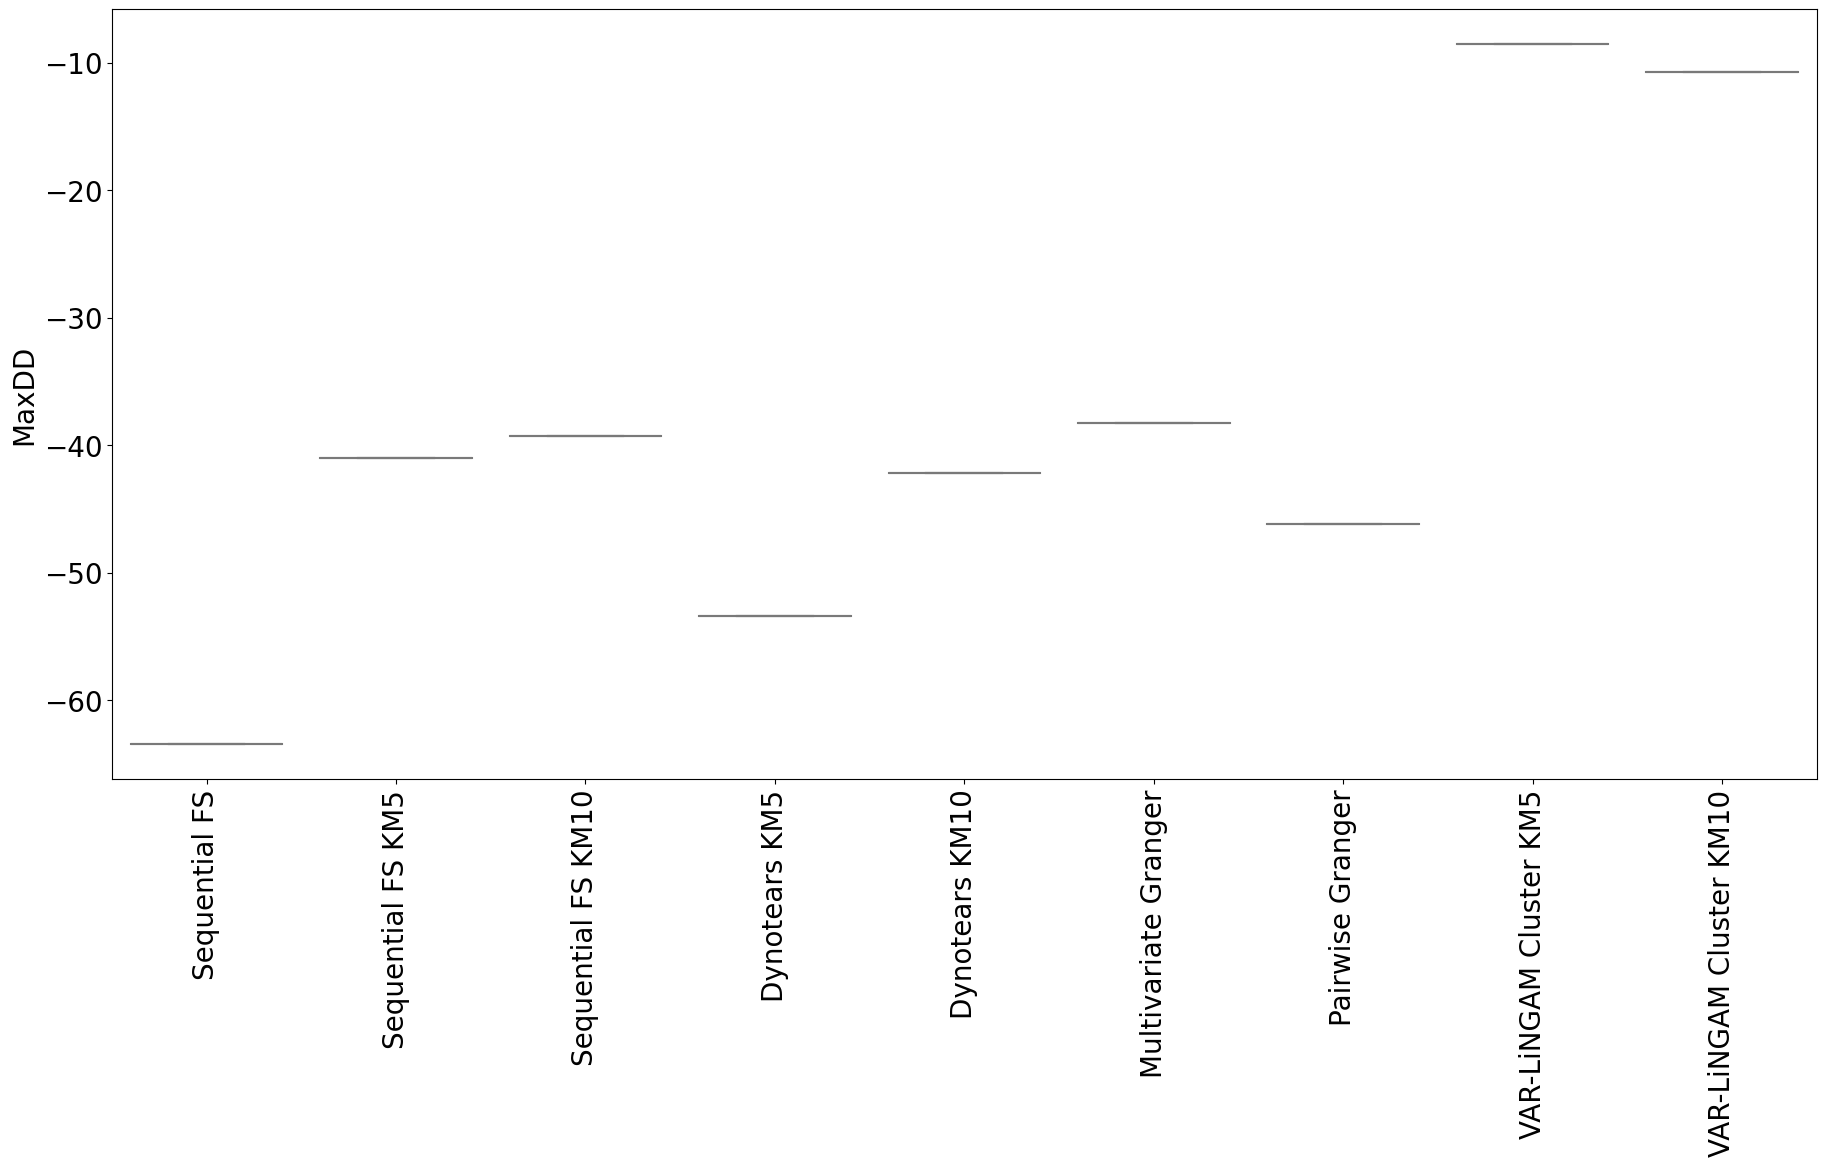

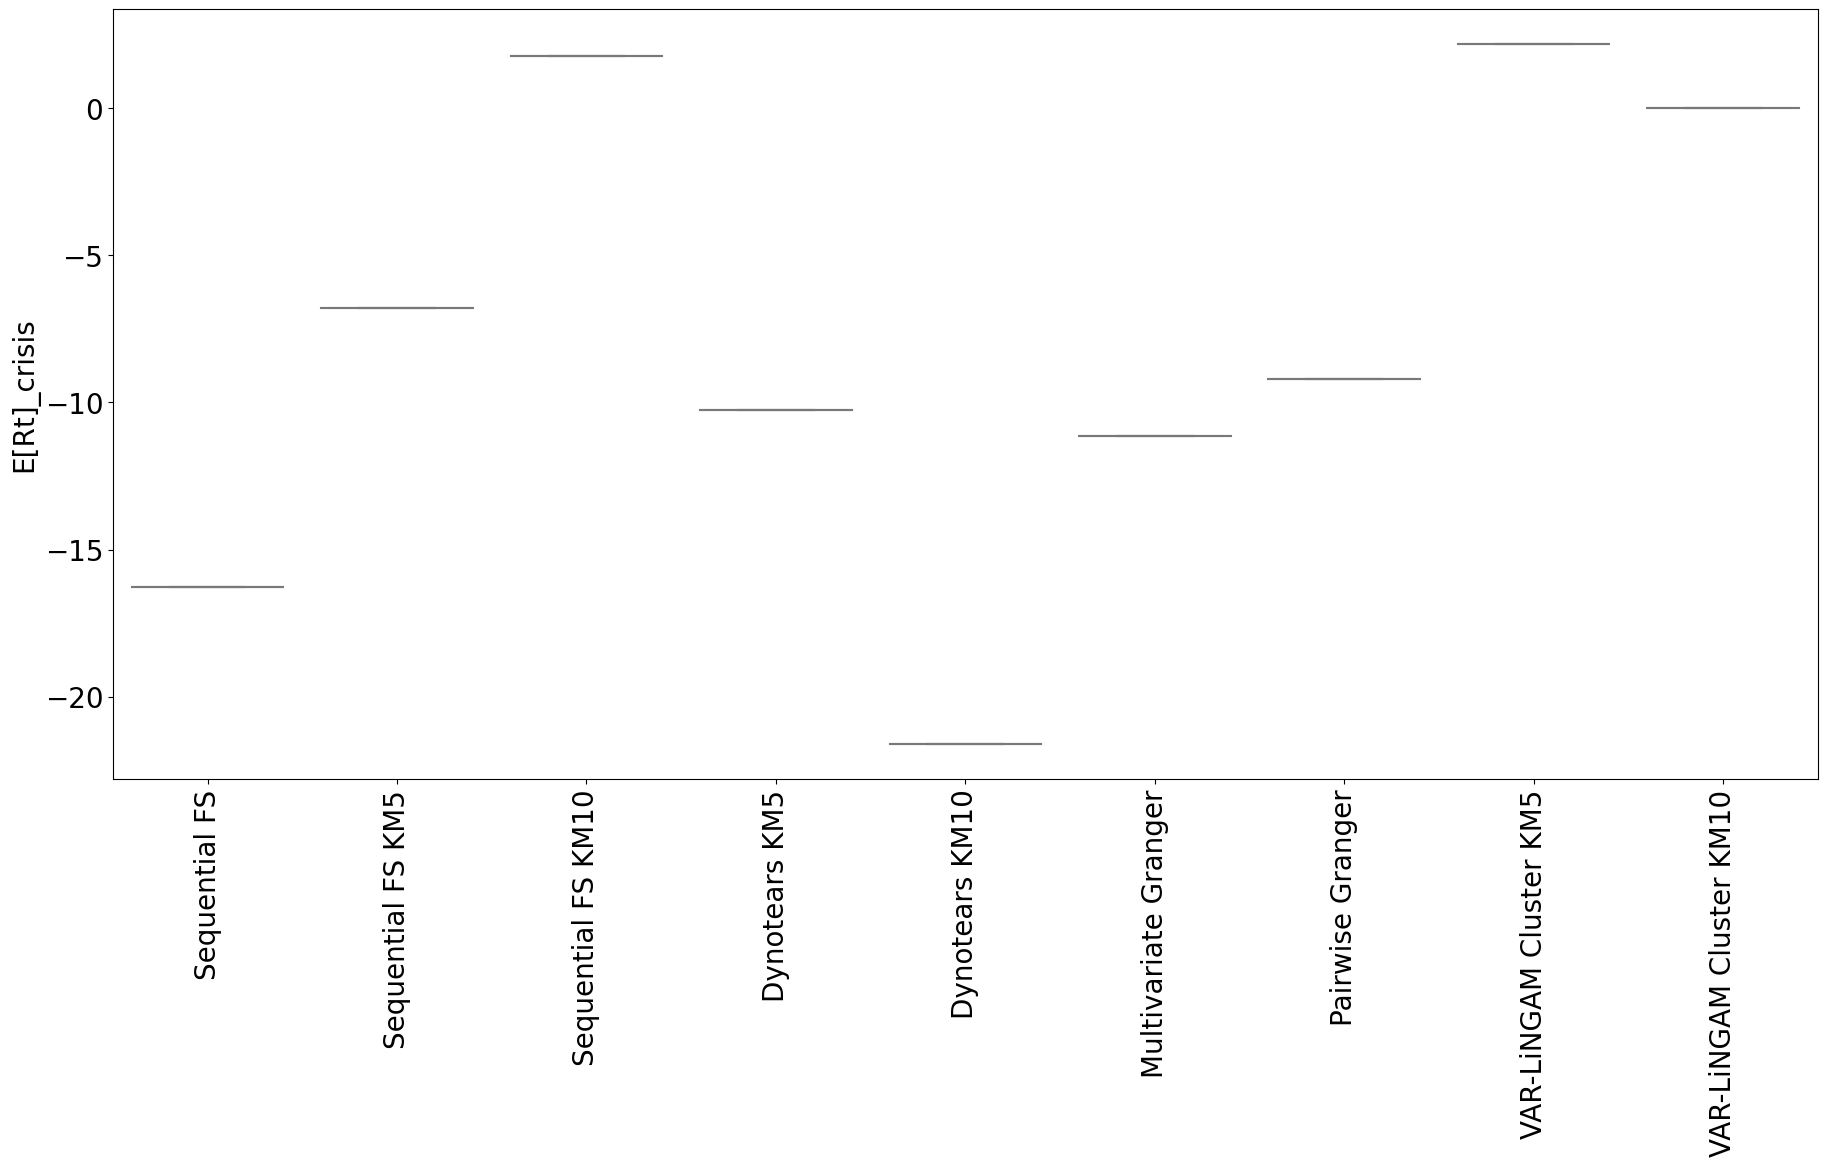

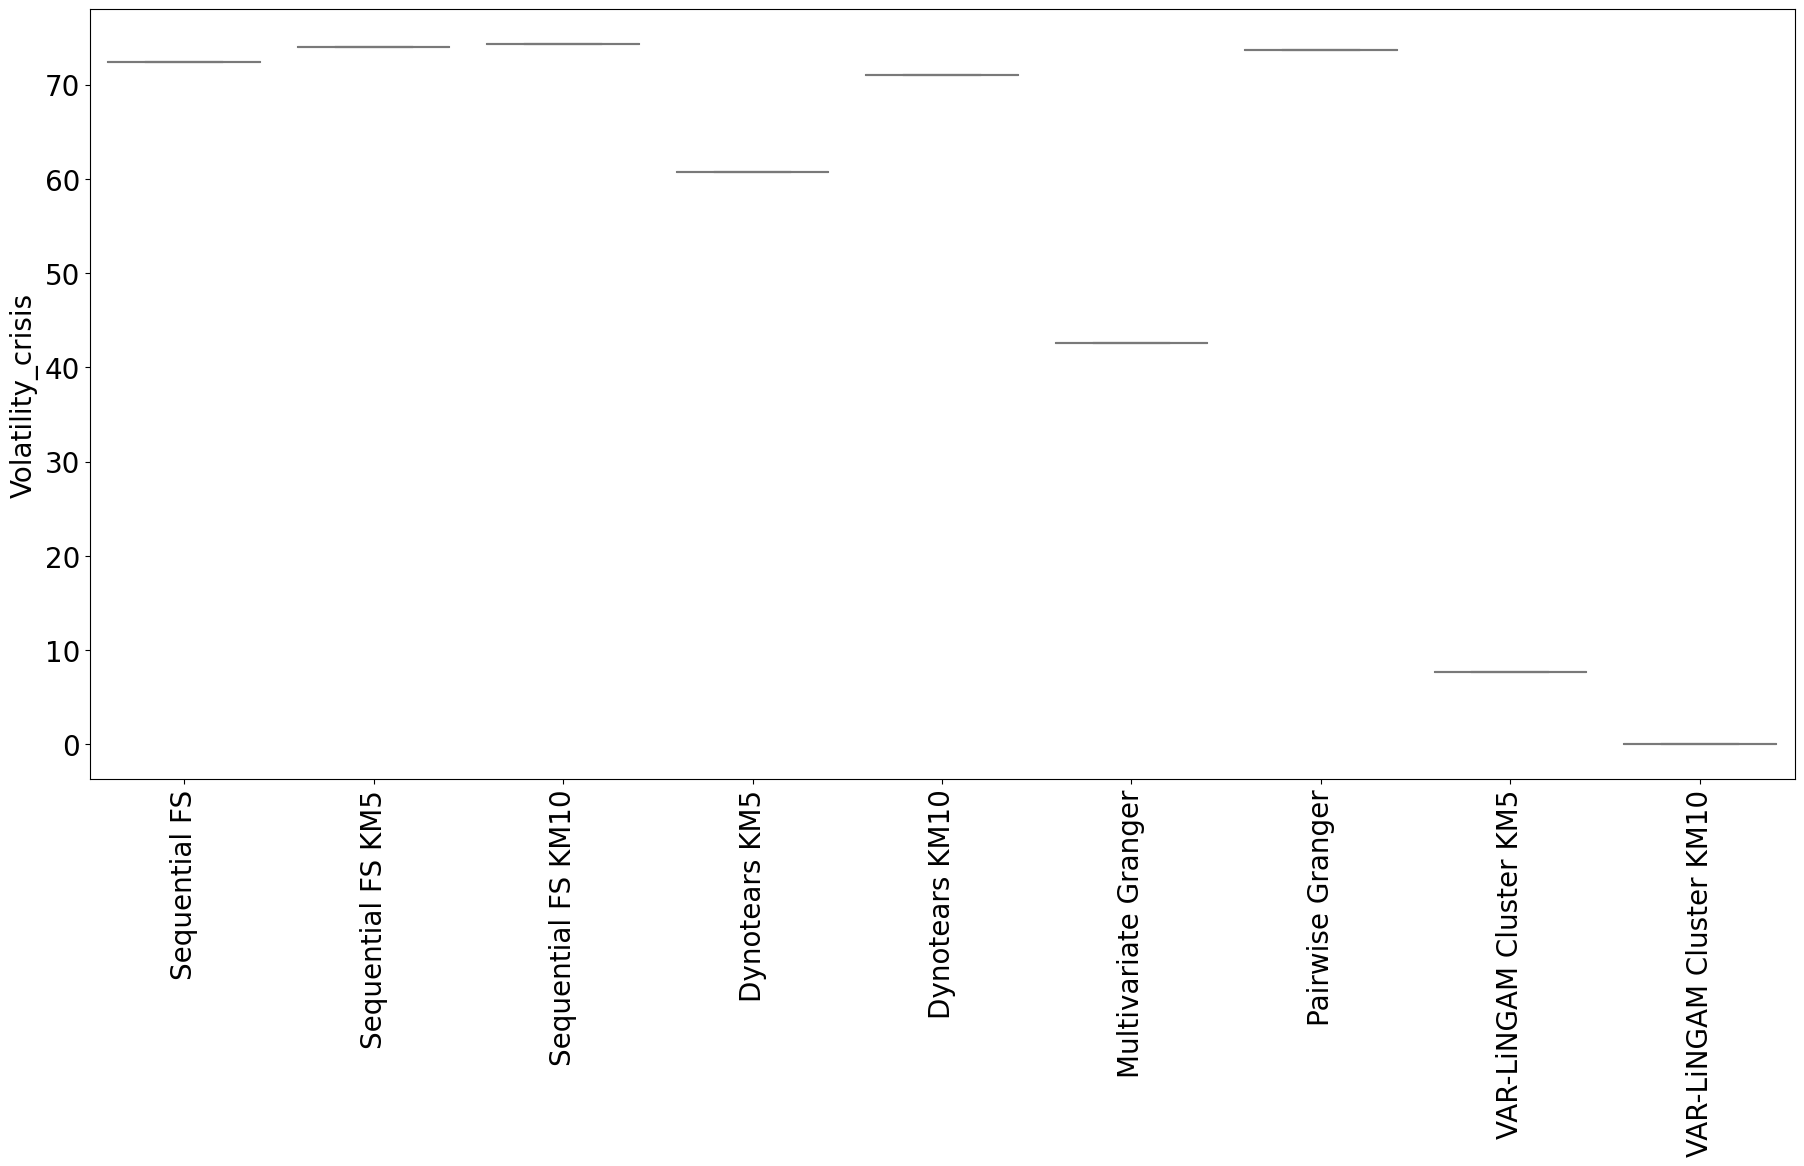

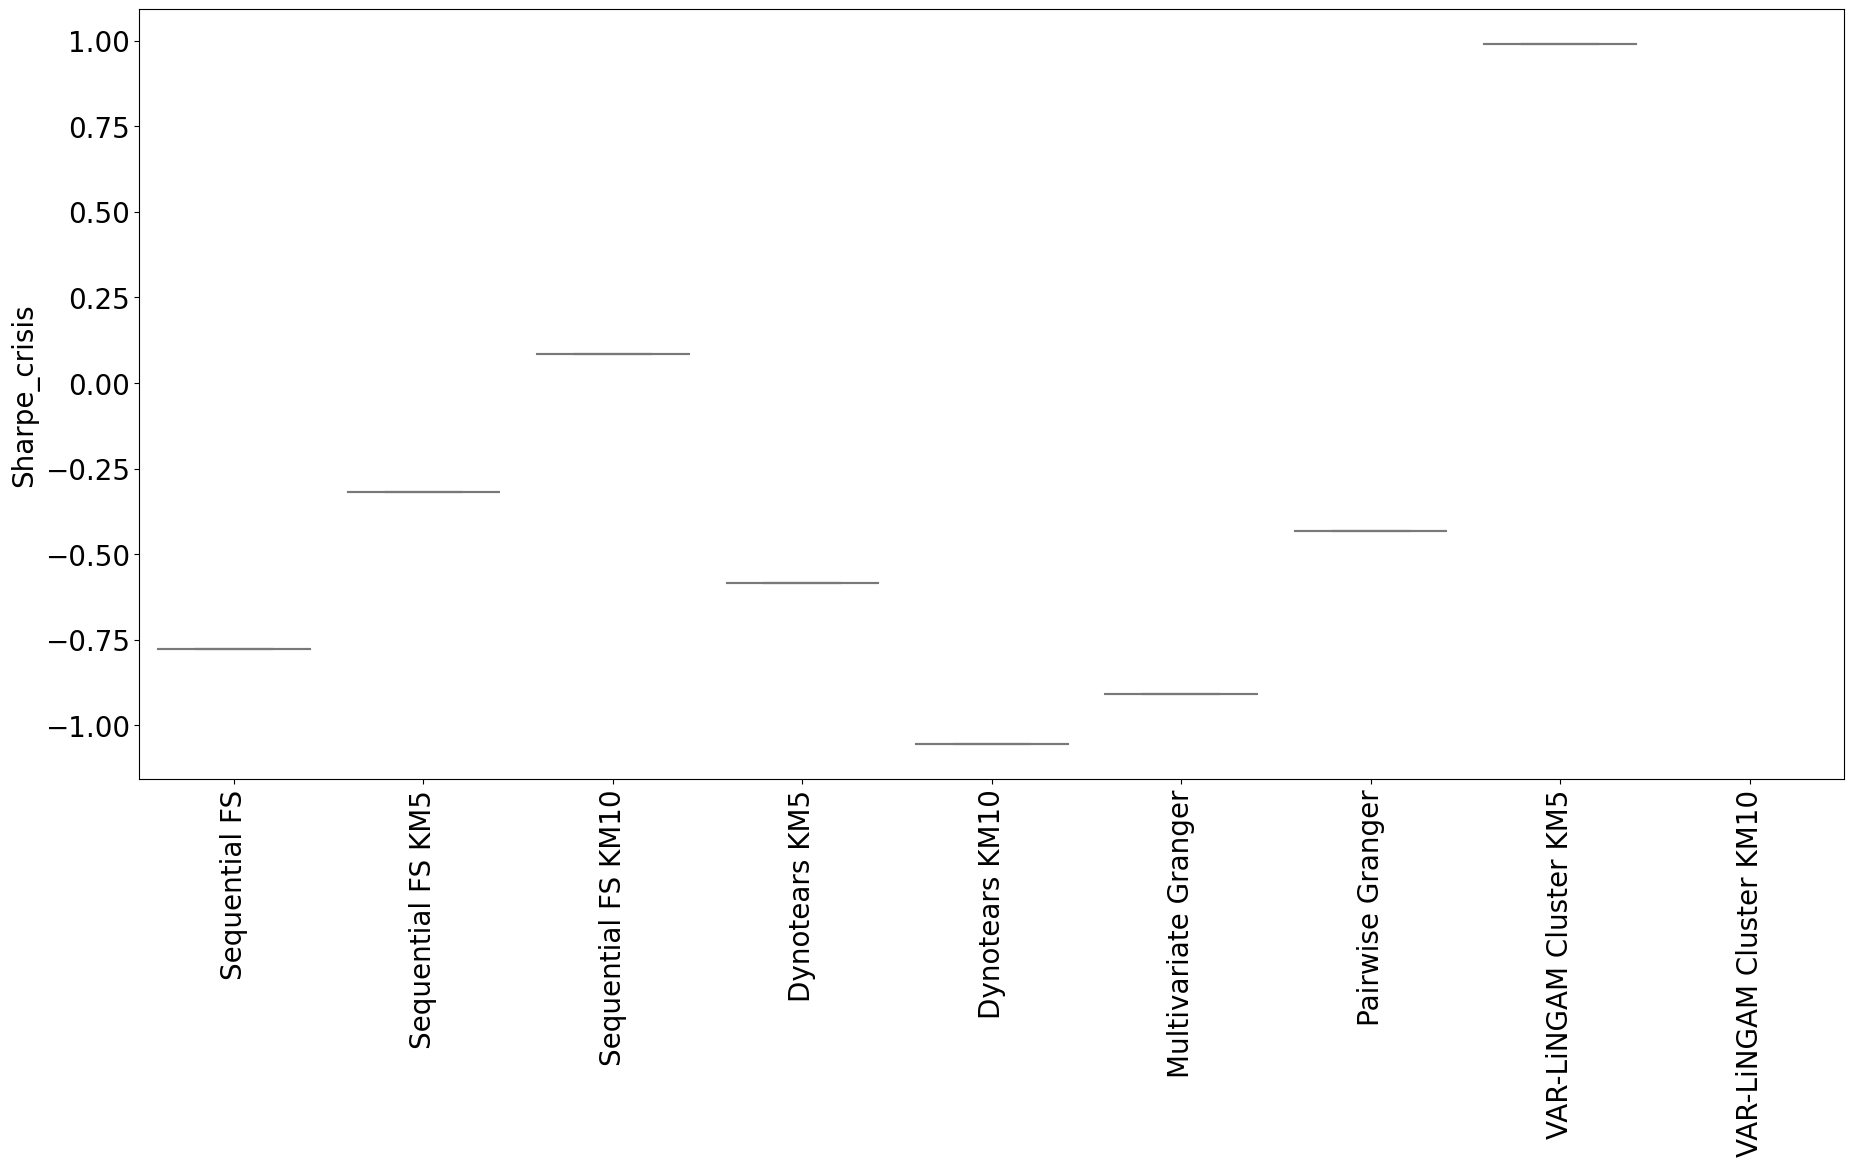

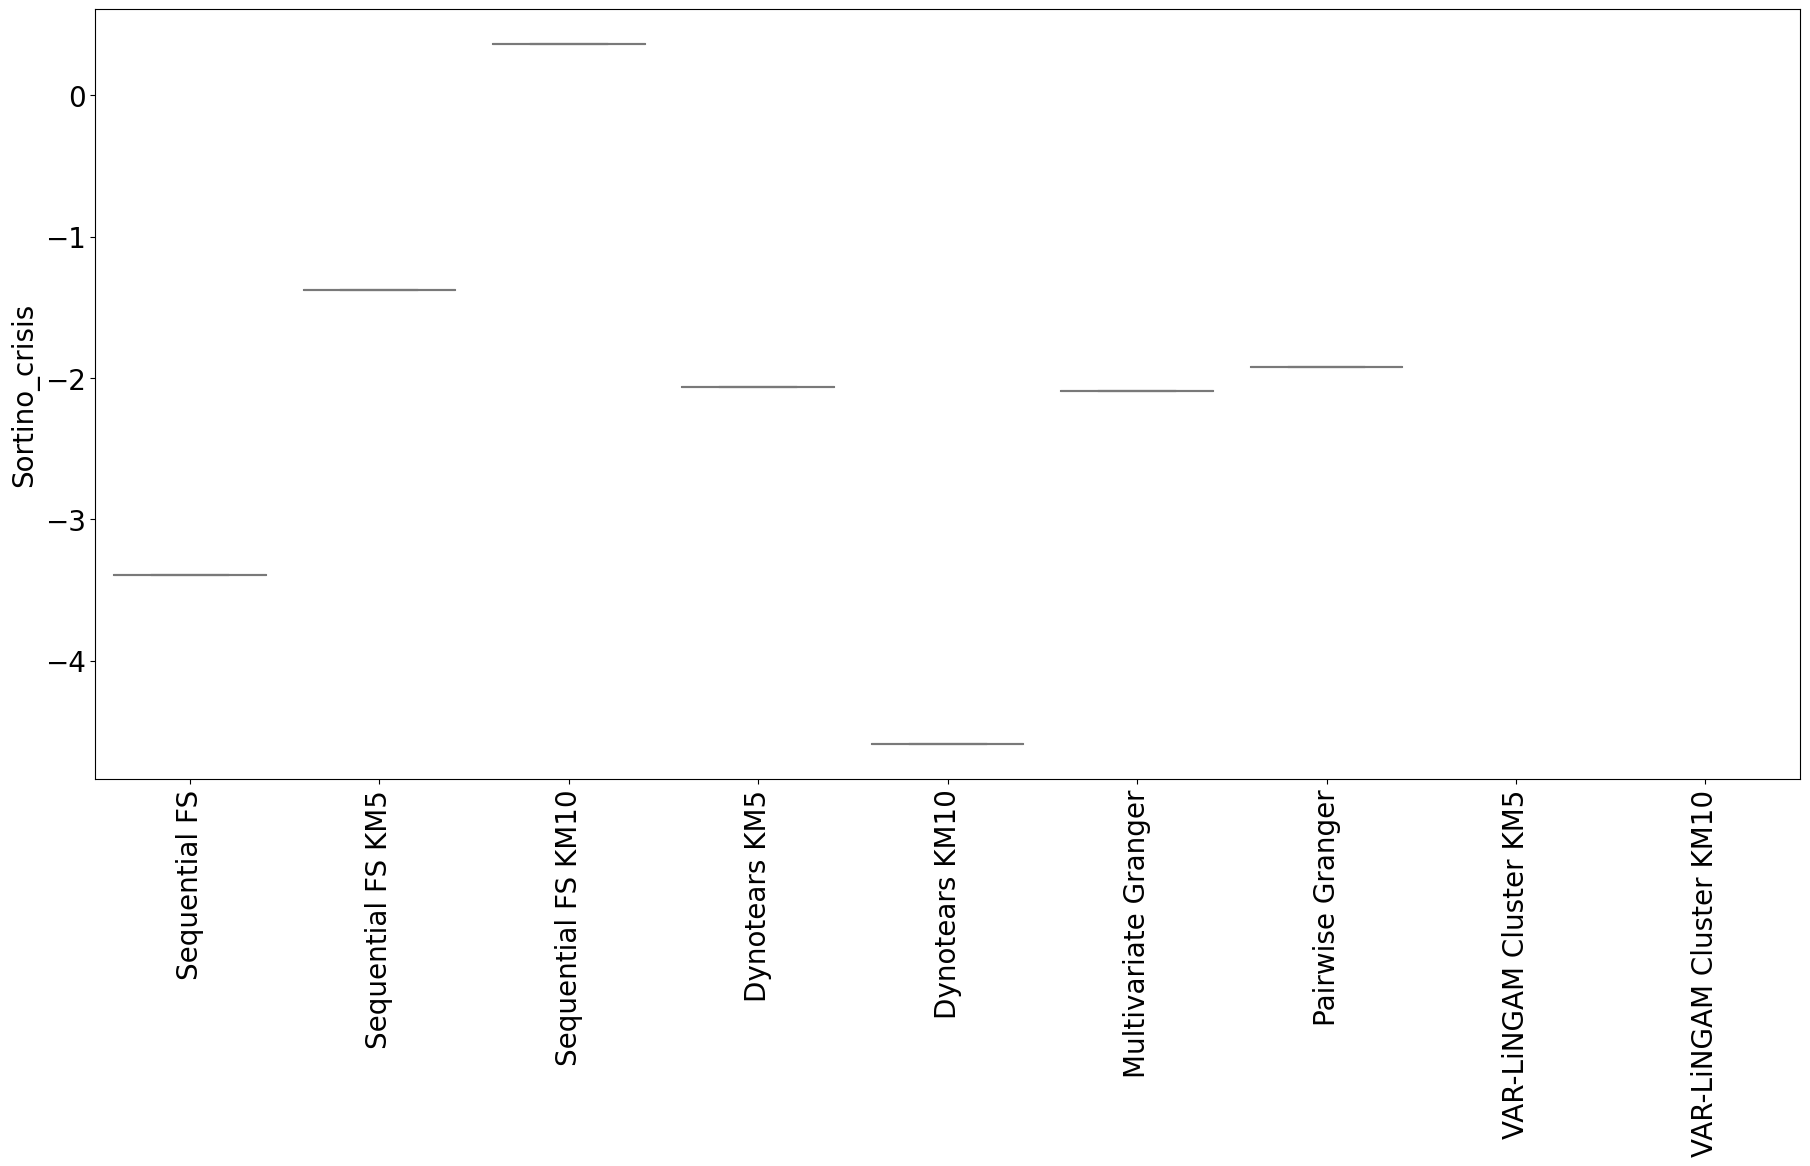

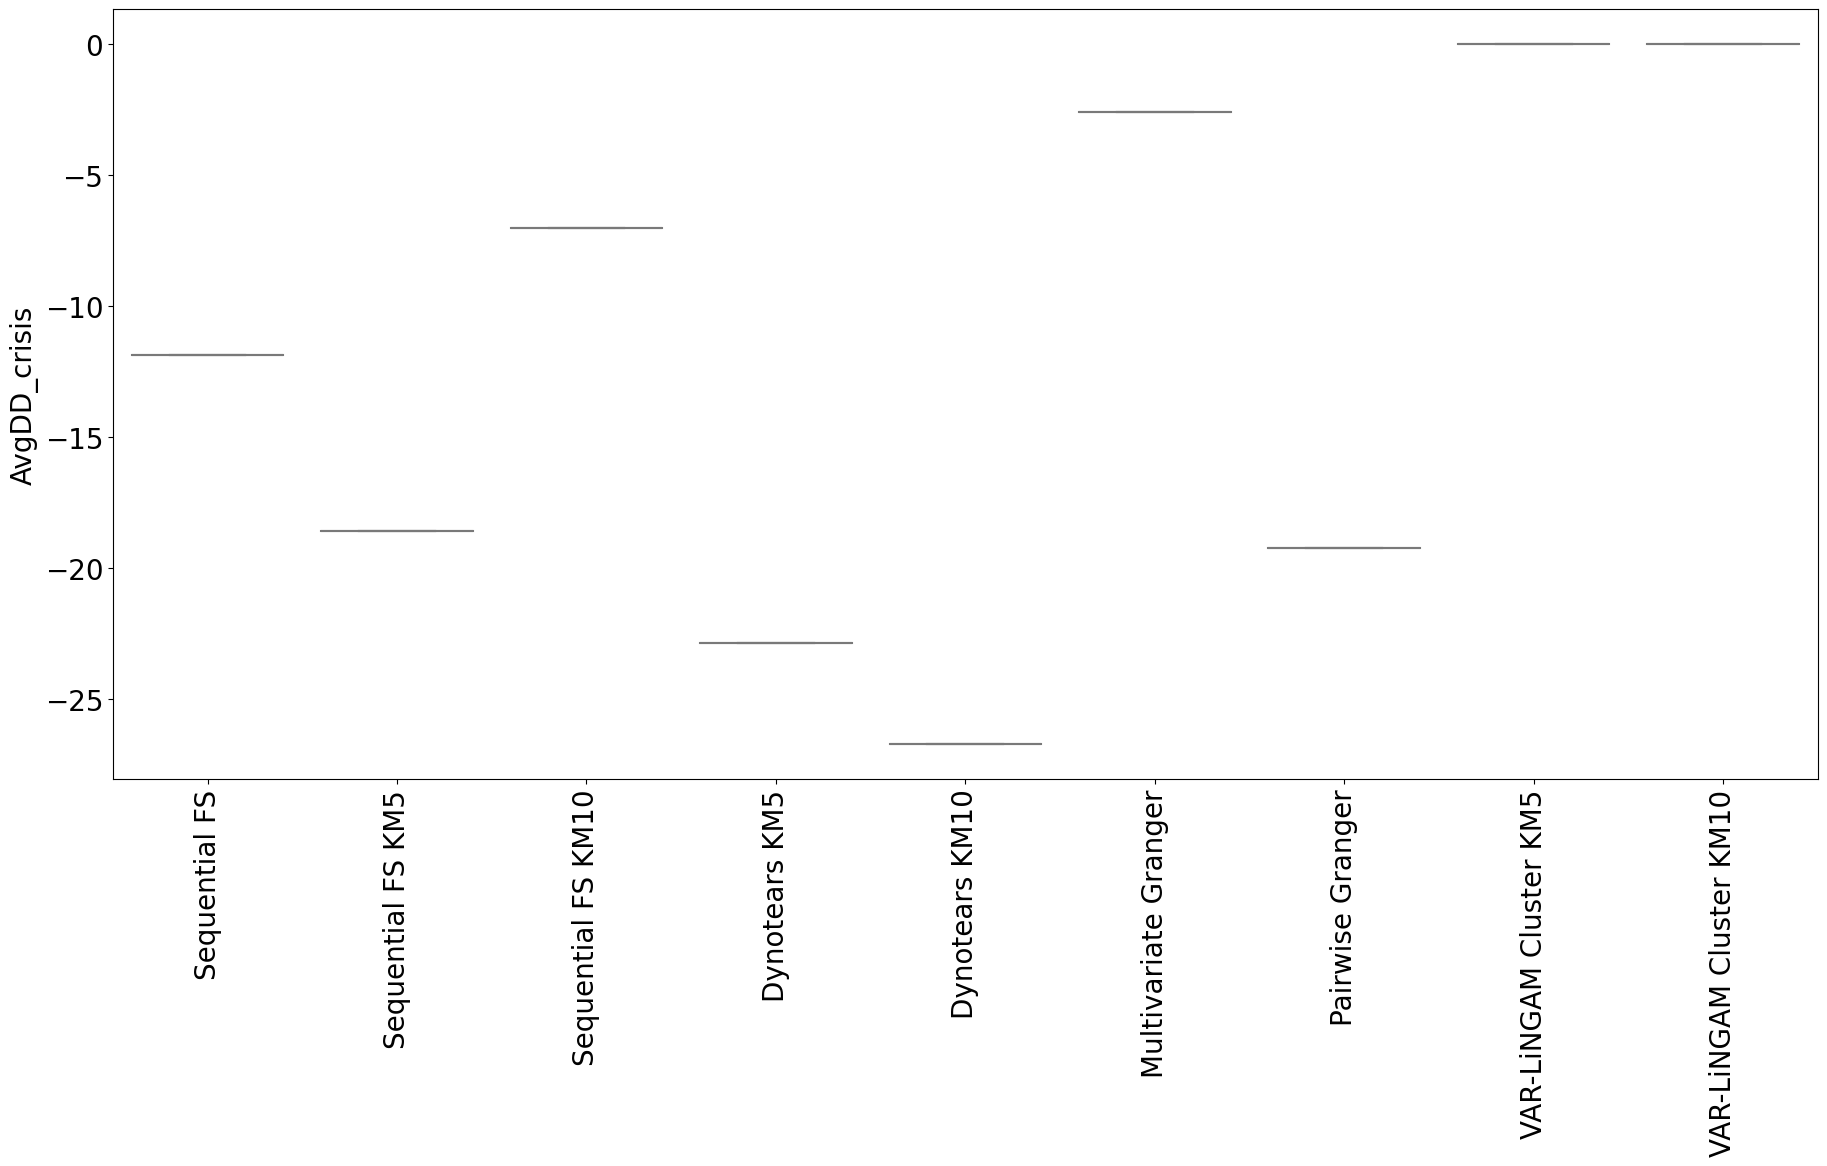

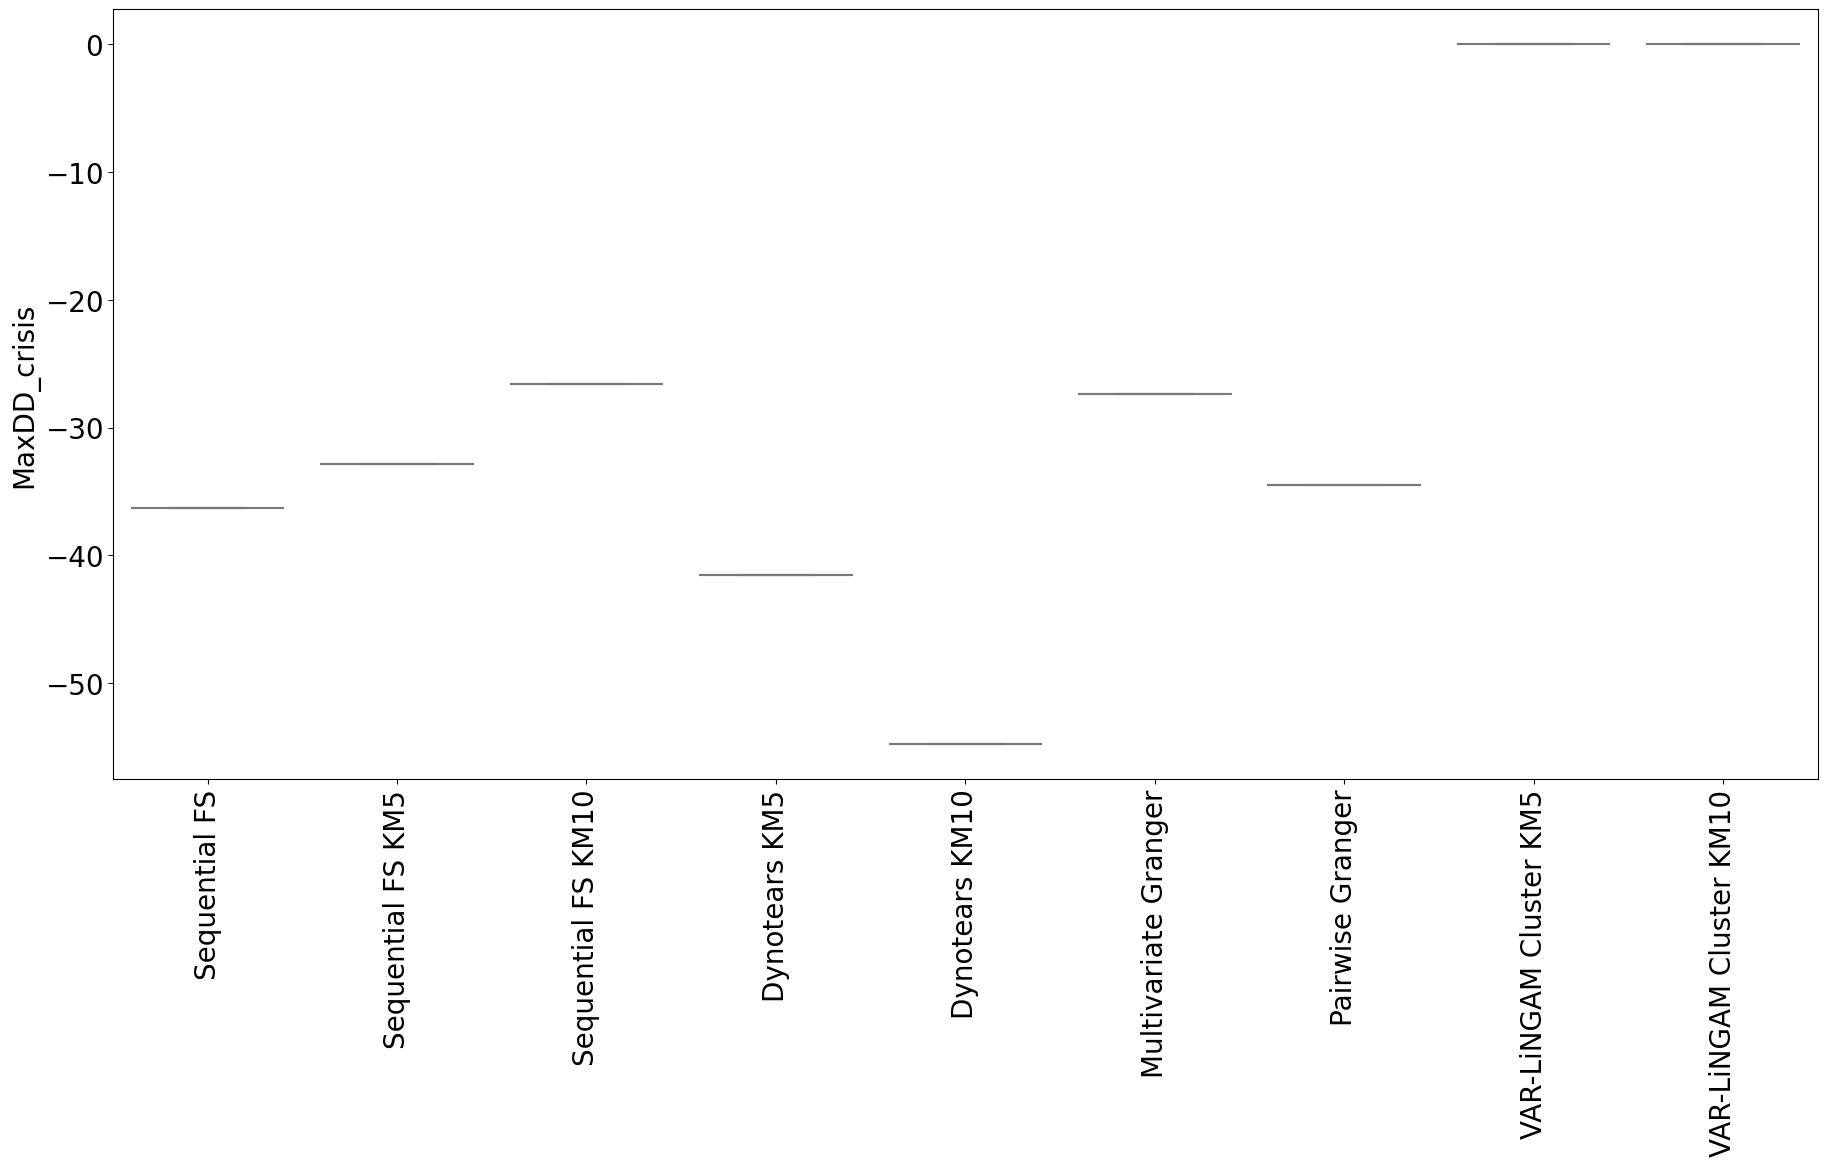

In [8]:
for measure in all_measures_df["variable"].unique():
    boxplot_df = all_measures_df.loc[(all_measures_df["variable"] == measure)&
                                     (~all_measures_df["index"].isin(etfs_large))].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="index", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(measure, fontsize=20)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{measure}_fs.png'))

### Plot Cumulative Returns

In [9]:
target = "SPY"

tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
tmp_dfPnl = tmp_dfPnl.reset_index()

tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()
tmp_dfPnl.rename(columns={"": "date"}, inplace=True)

tmp_dfPnl.to_csv(os.path.join(results_path, f"{target}_pnl.csv"))

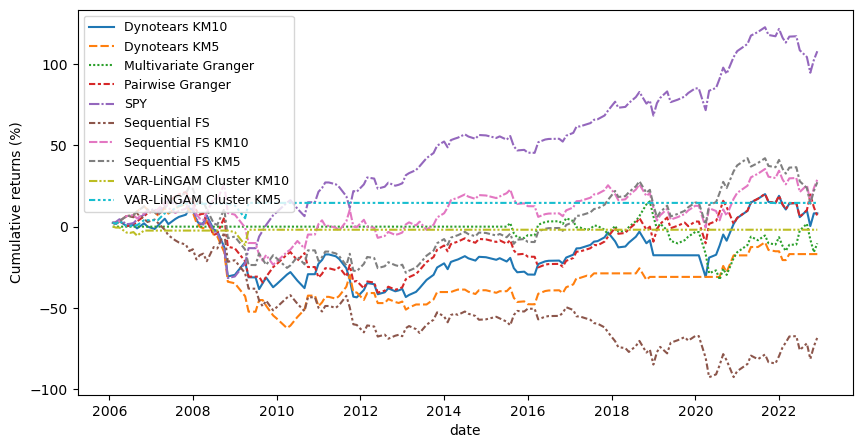

In [10]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()
    tmp_dfPnl.columns.name = ""
    
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    sns.lineplot(data = tmp_dfPnl.cumsum() * 100, ax = ax)
    ax.set_ylabel("Cumulative returns (%)")
    # ax.set_title(target)
    ax.legend(loc='upper left', prop={'size': 9})

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_cum_ret.png"))

### Plot Rolling Sharpe Ratios

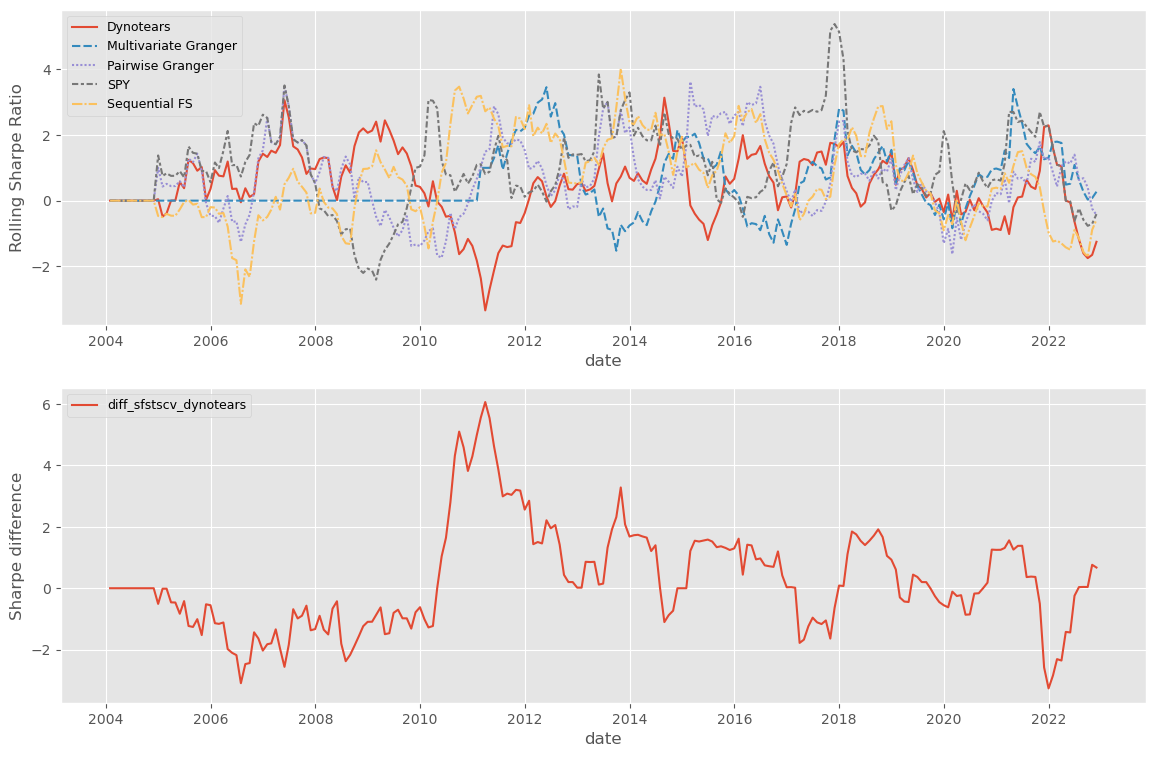

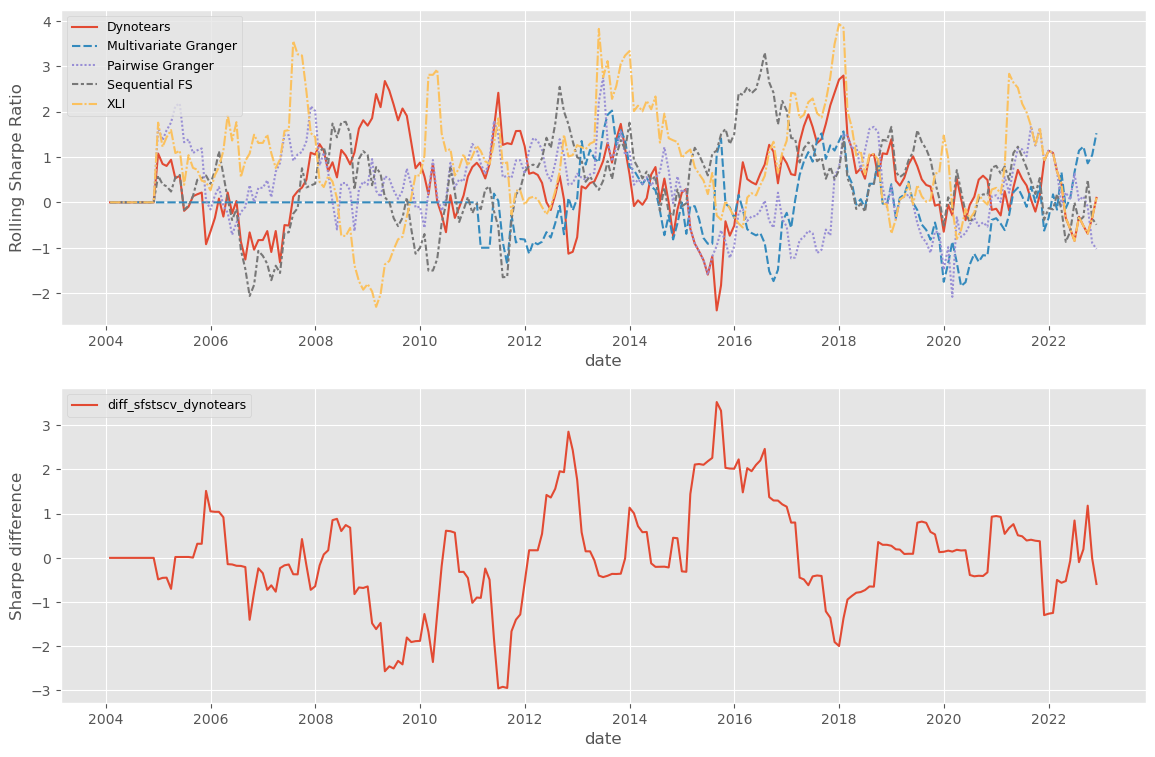

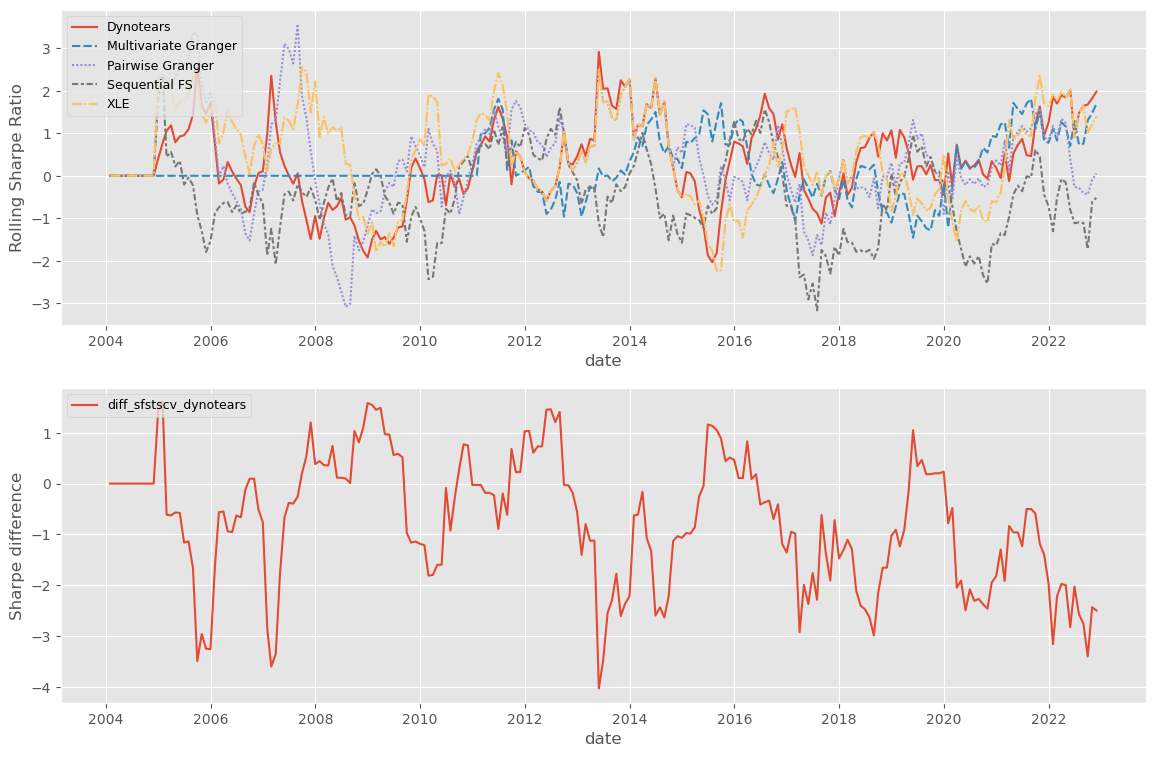

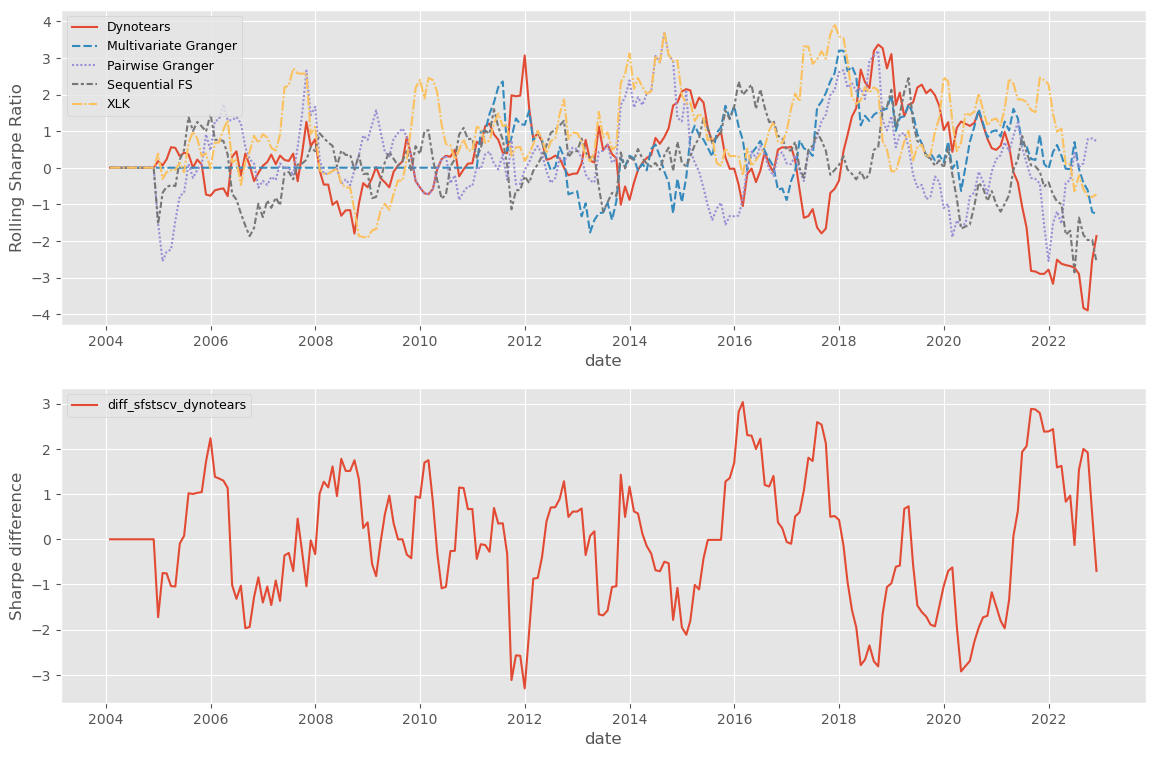

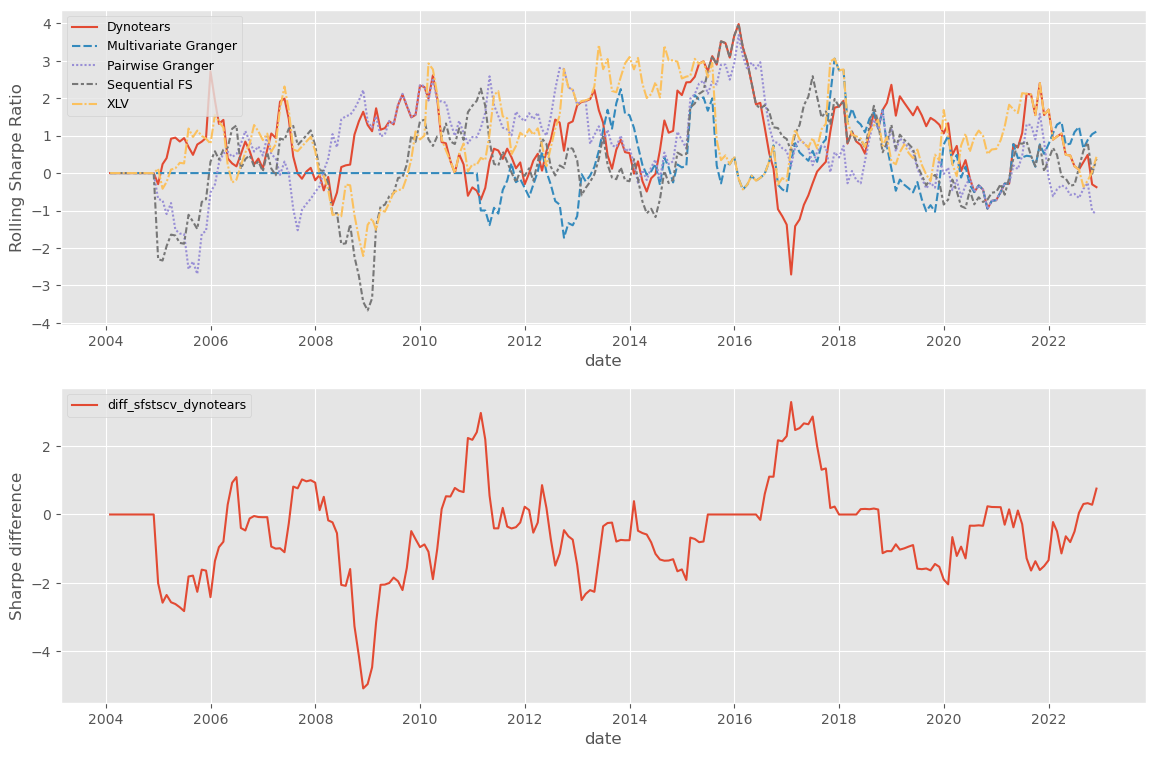

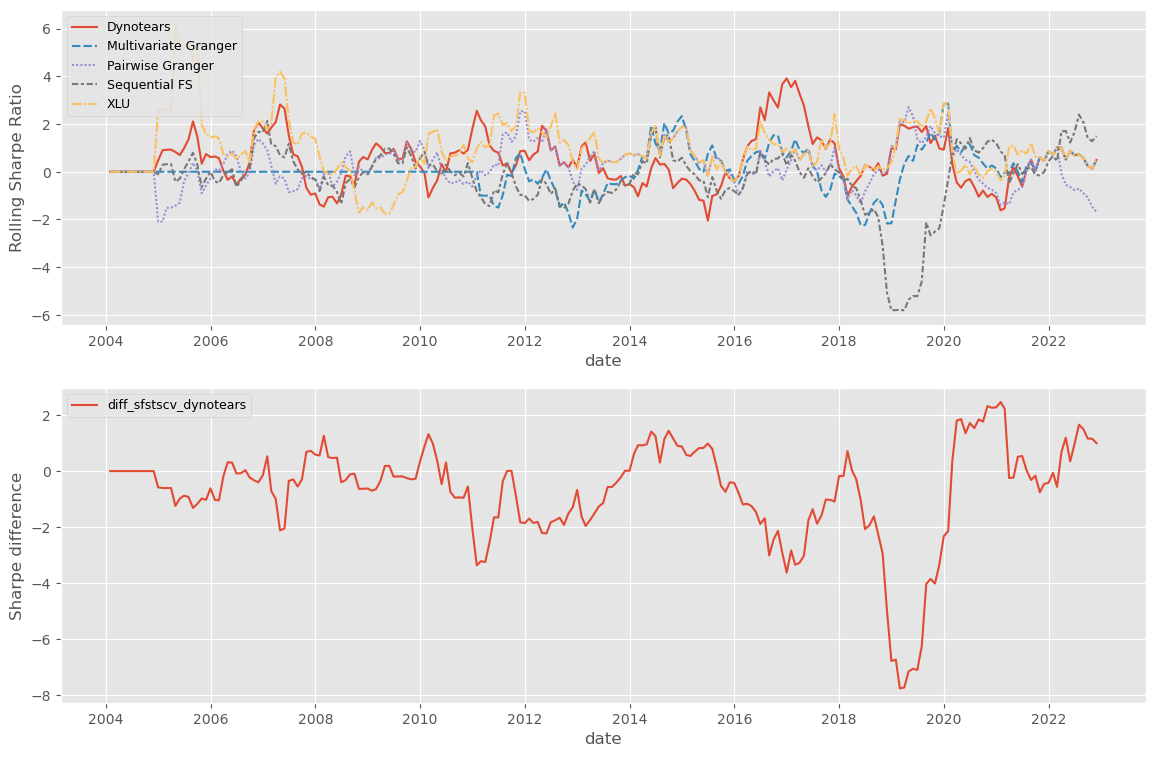

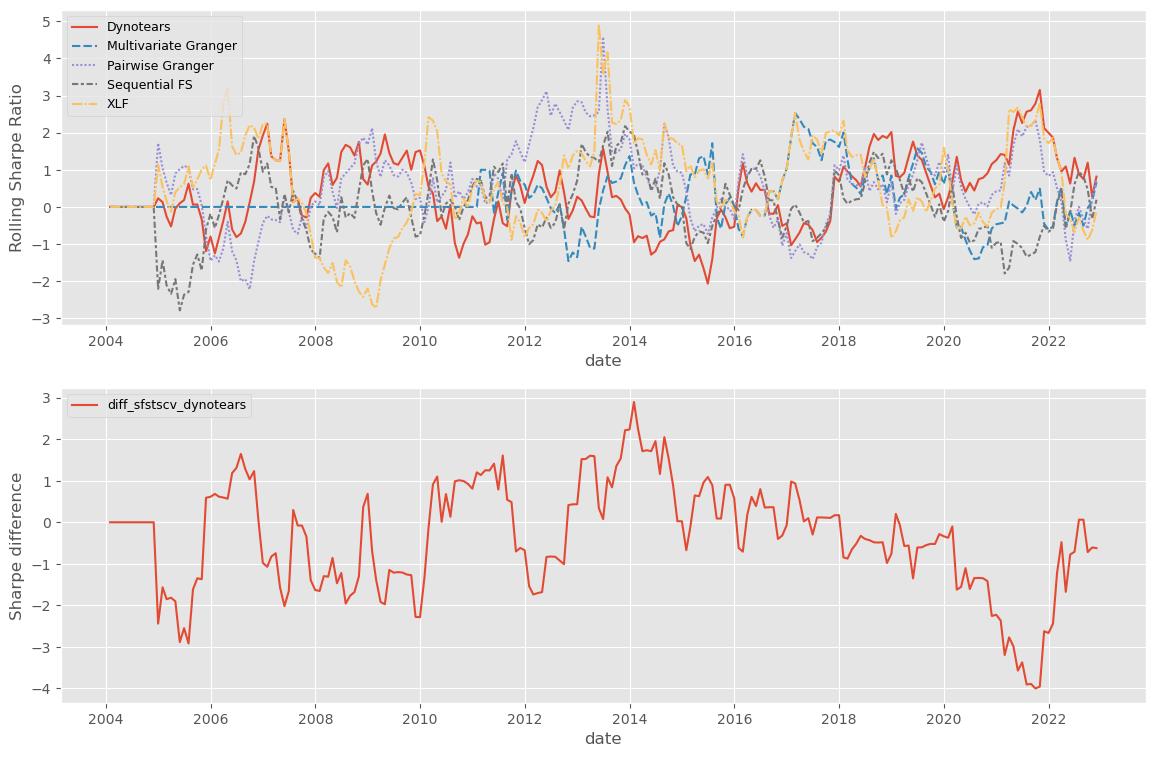

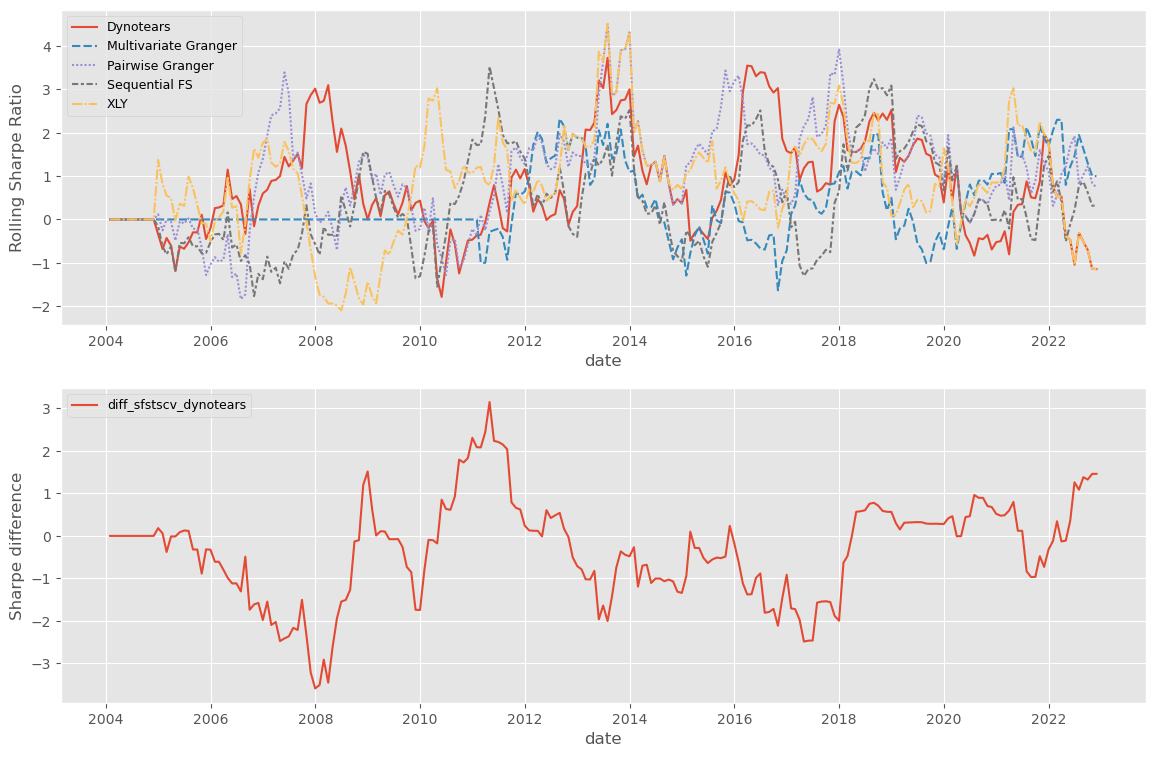

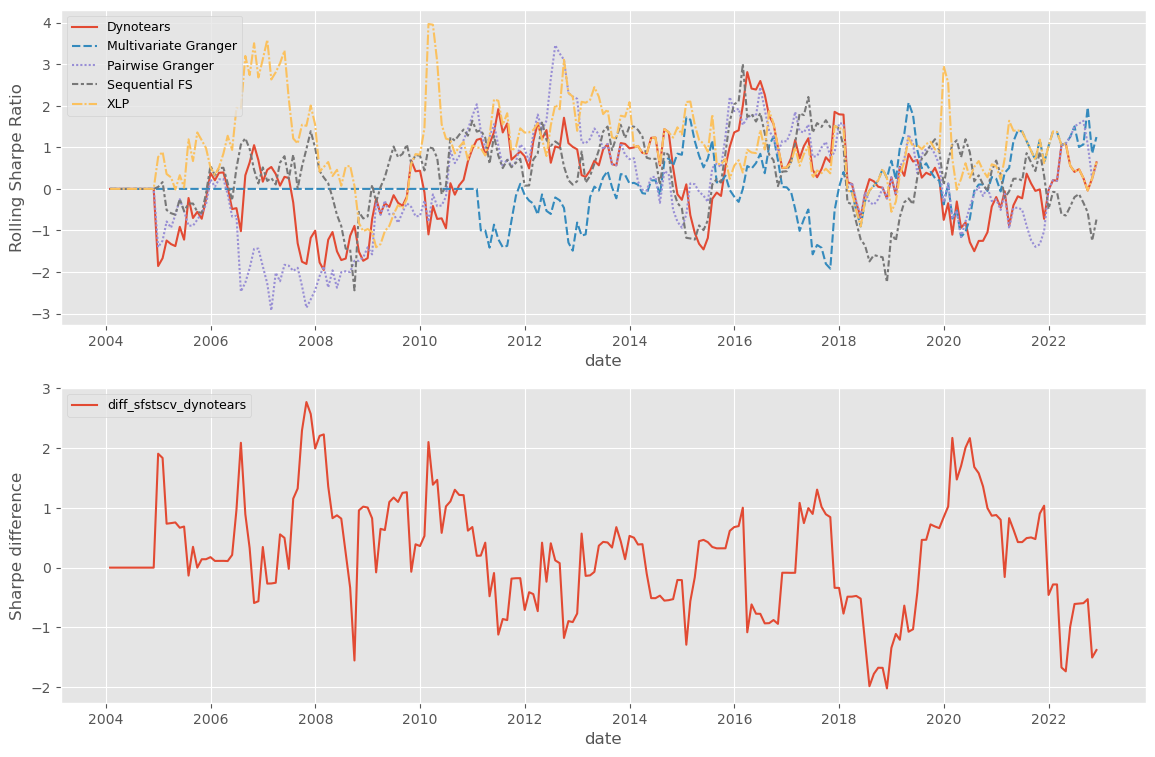

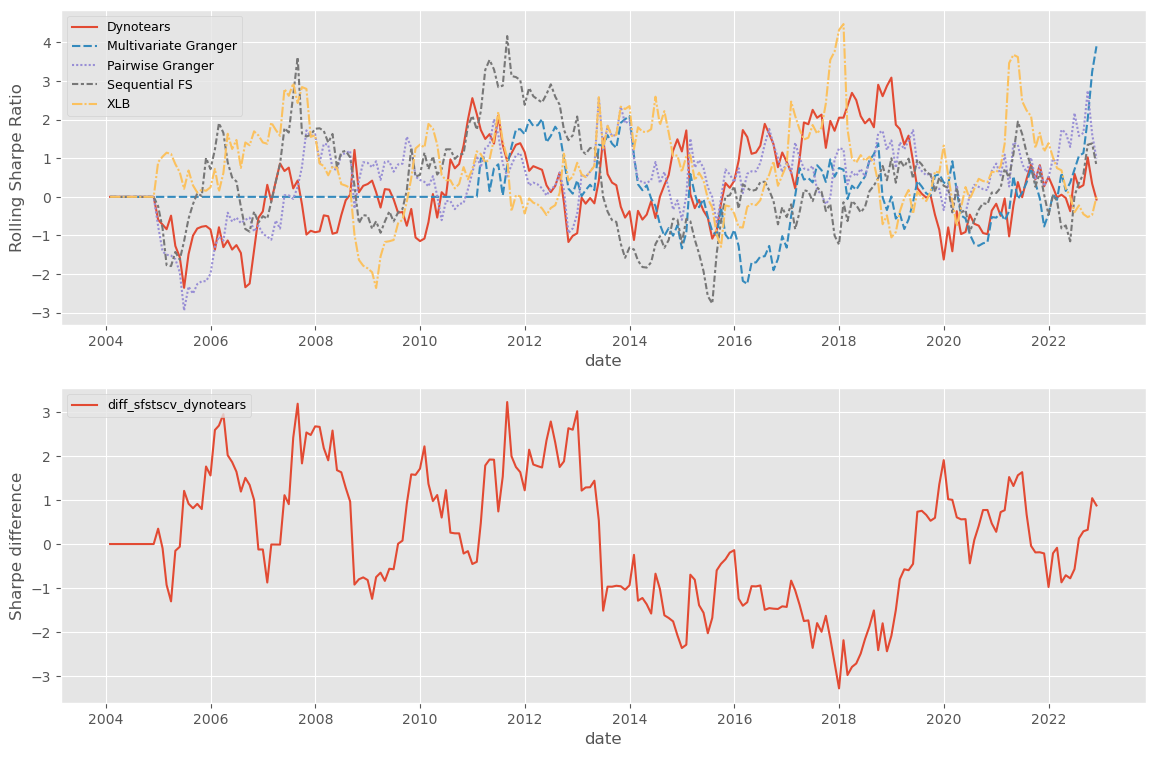

In [29]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    rolling_sharpe_df = tmp_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0).fillna(0)
    rolling_sharpe_diff_df = pd.DataFrame(rolling_sharpe_df["Sequential FS"] - rolling_sharpe_df["Dynotears"], columns=["diff_sfstscv_dynotears"])
    rolling_sharpe_diff_df = rolling_sharpe_diff_df.fillna(0)

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = rolling_sharpe_df, ax = ax[0])
    ax[0].set_ylabel("Rolling Sharpe Ratio")
    sns.lineplot(data = rolling_sharpe_diff_df, ax = ax[1])
    ax[1].set_ylabel("Sharpe difference")

    # set position of legend
    ax[0].legend(loc='upper left', prop={'size': 9})
    ax[1].legend(loc='upper left', prop={'size': 9})

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_rolling_sharpe_fs.png"))

### Plot Cumulative Returns and Rolling Sharpe Ratios for Combined Portfolio

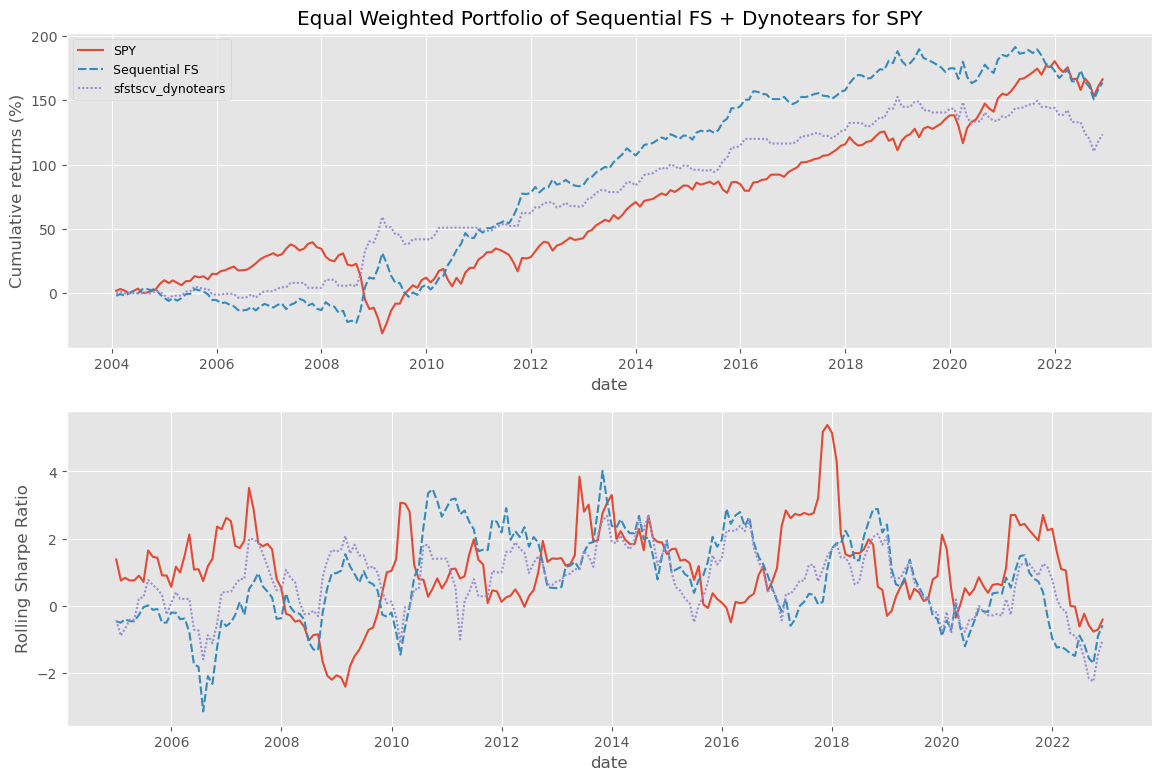

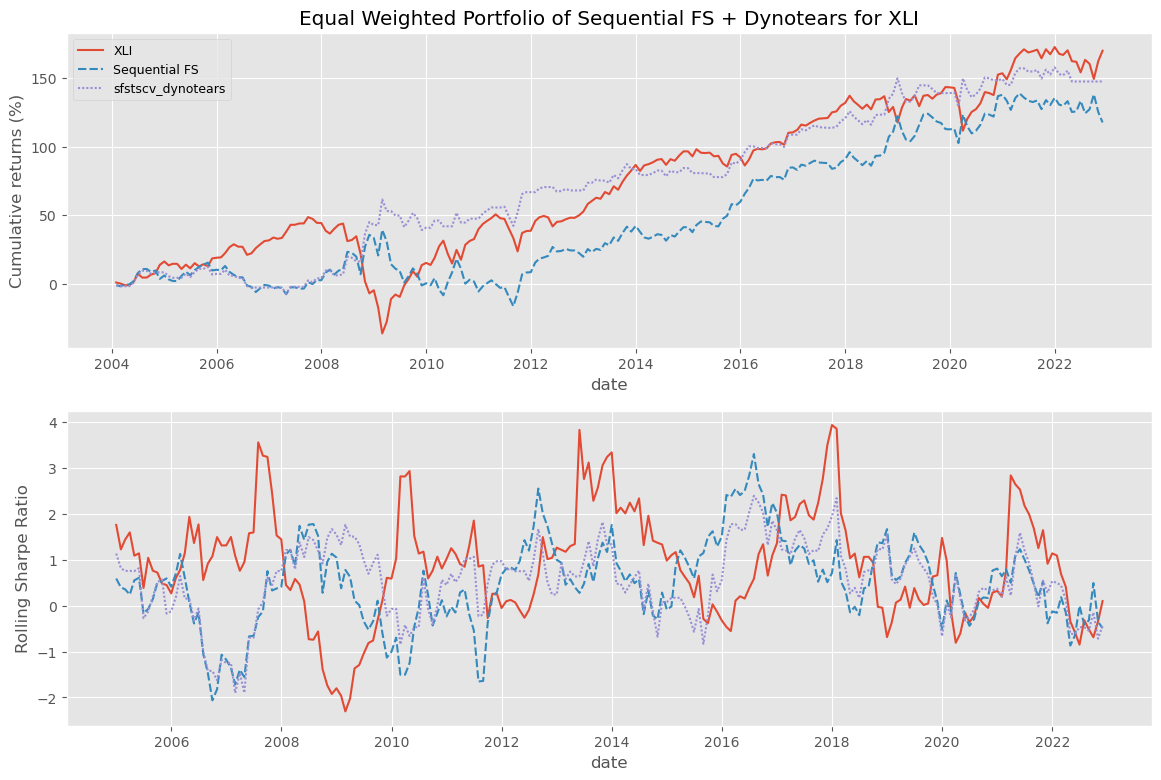

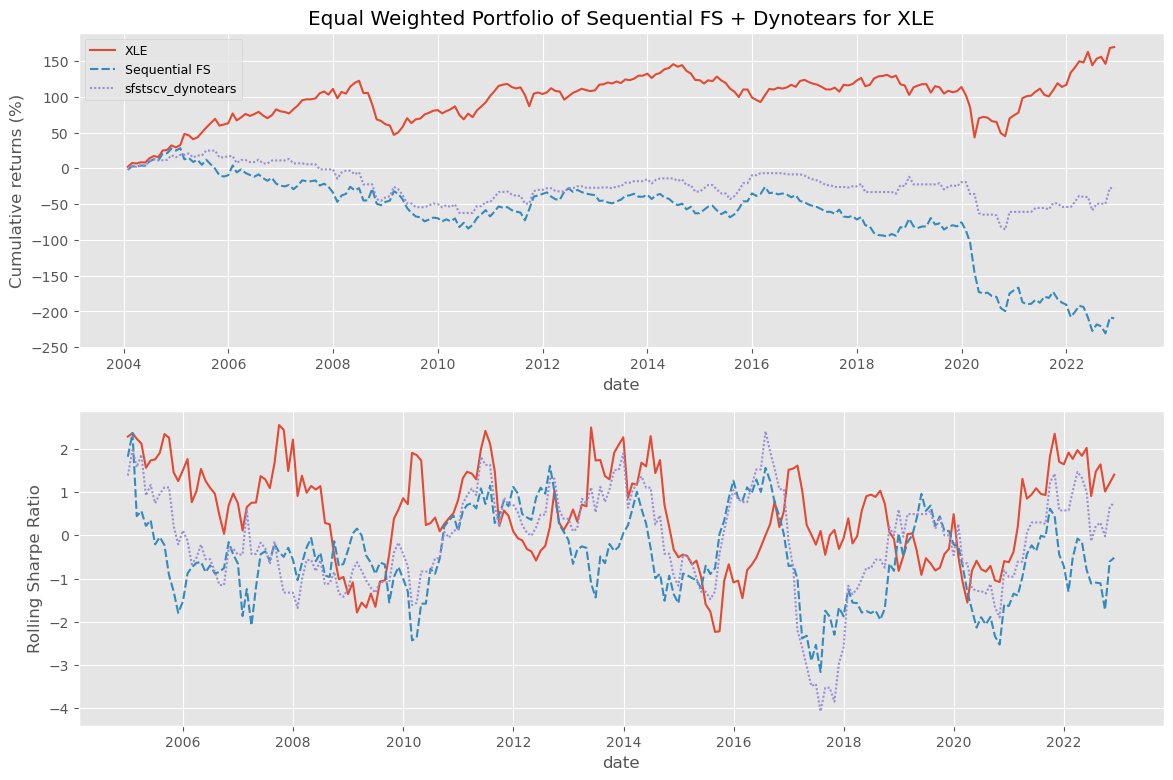

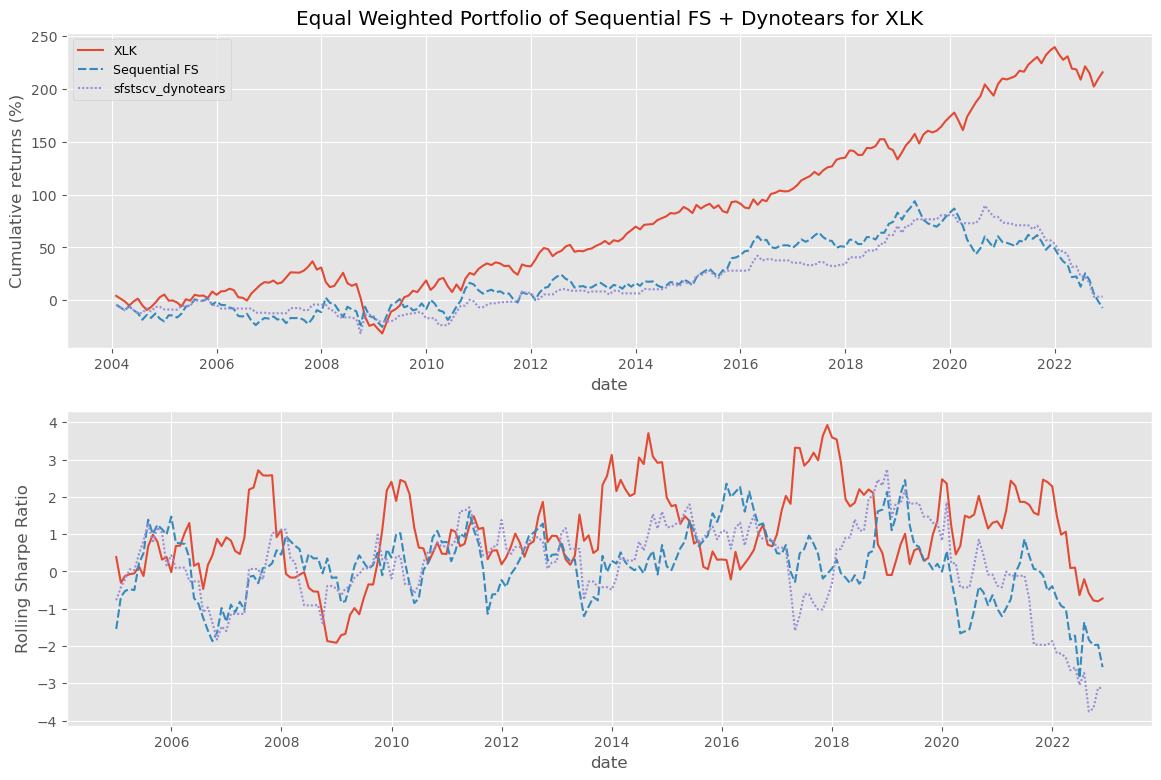

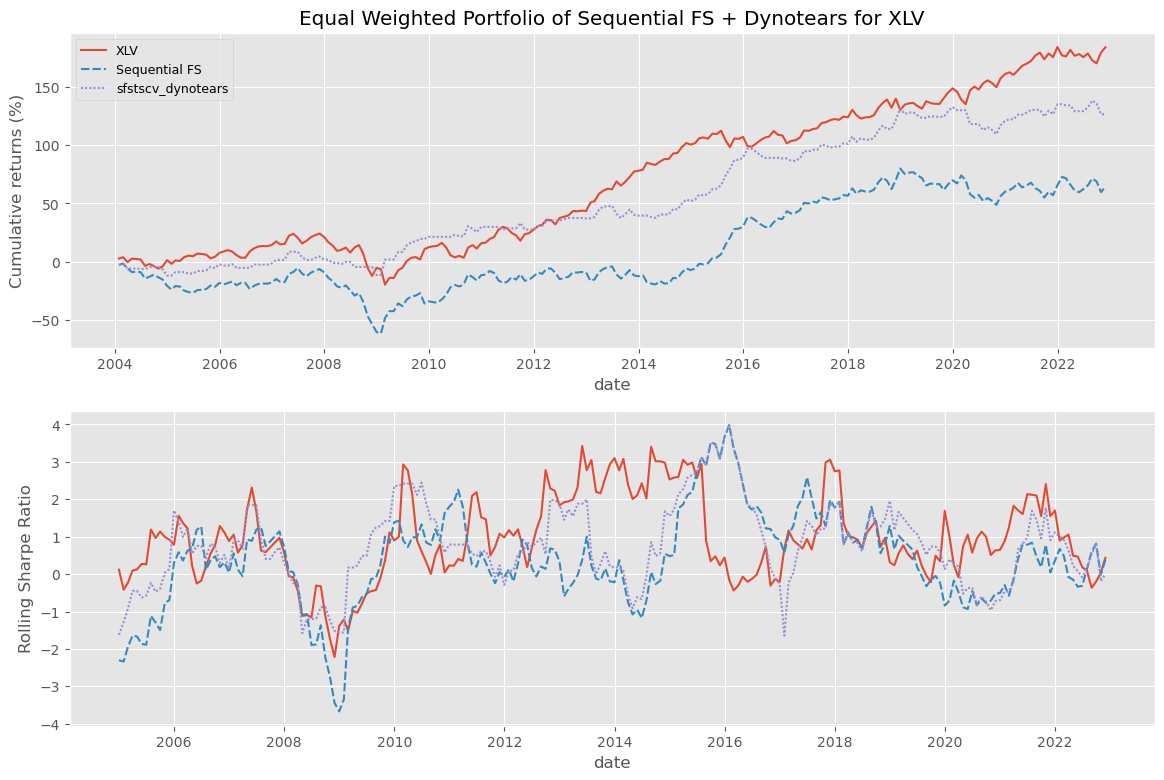

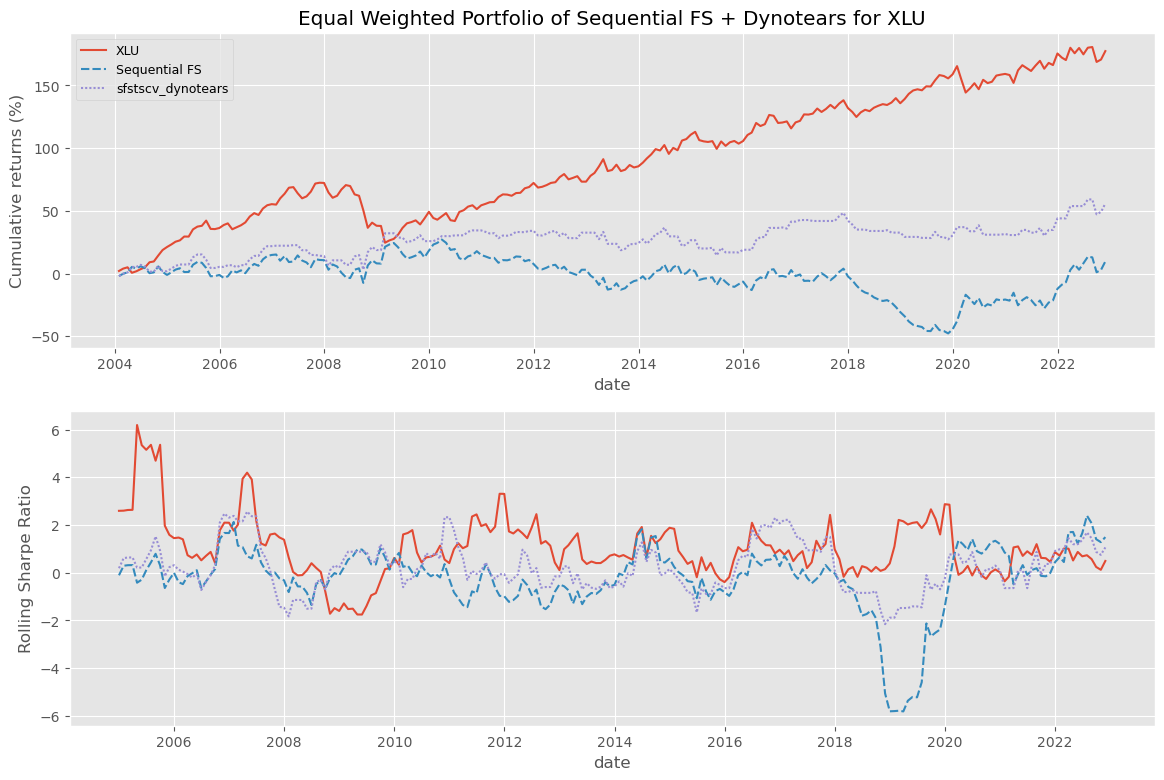

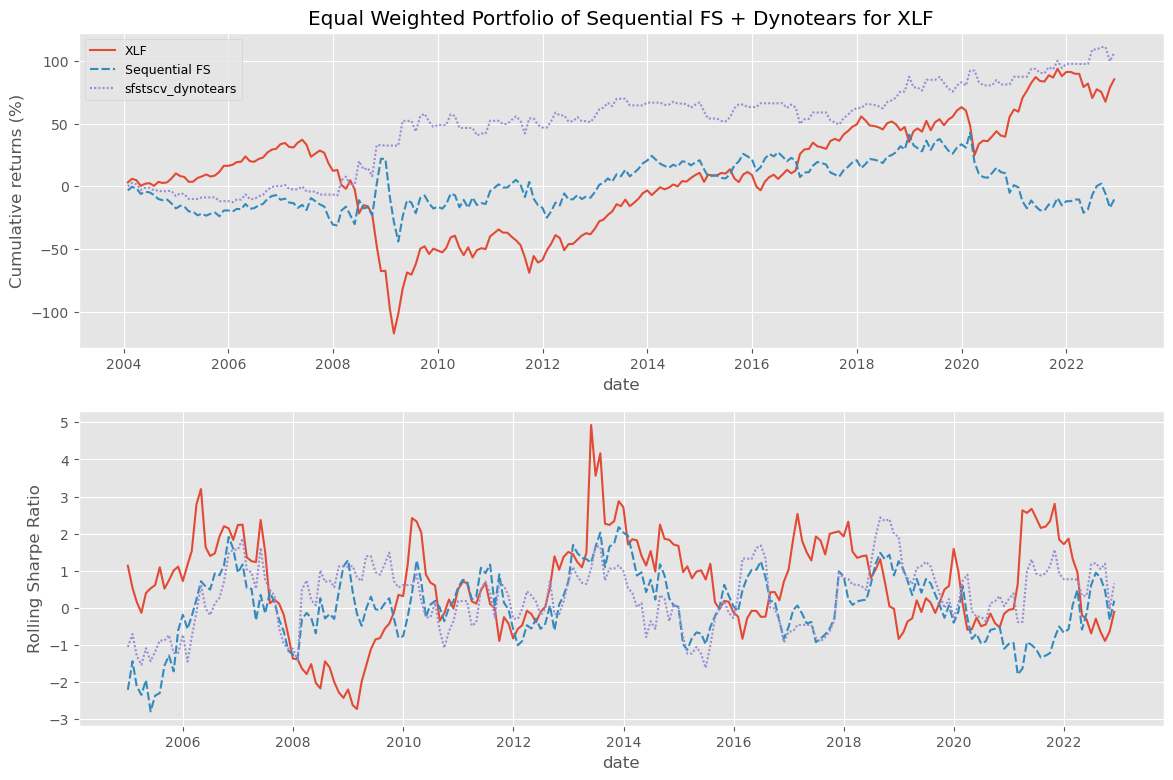

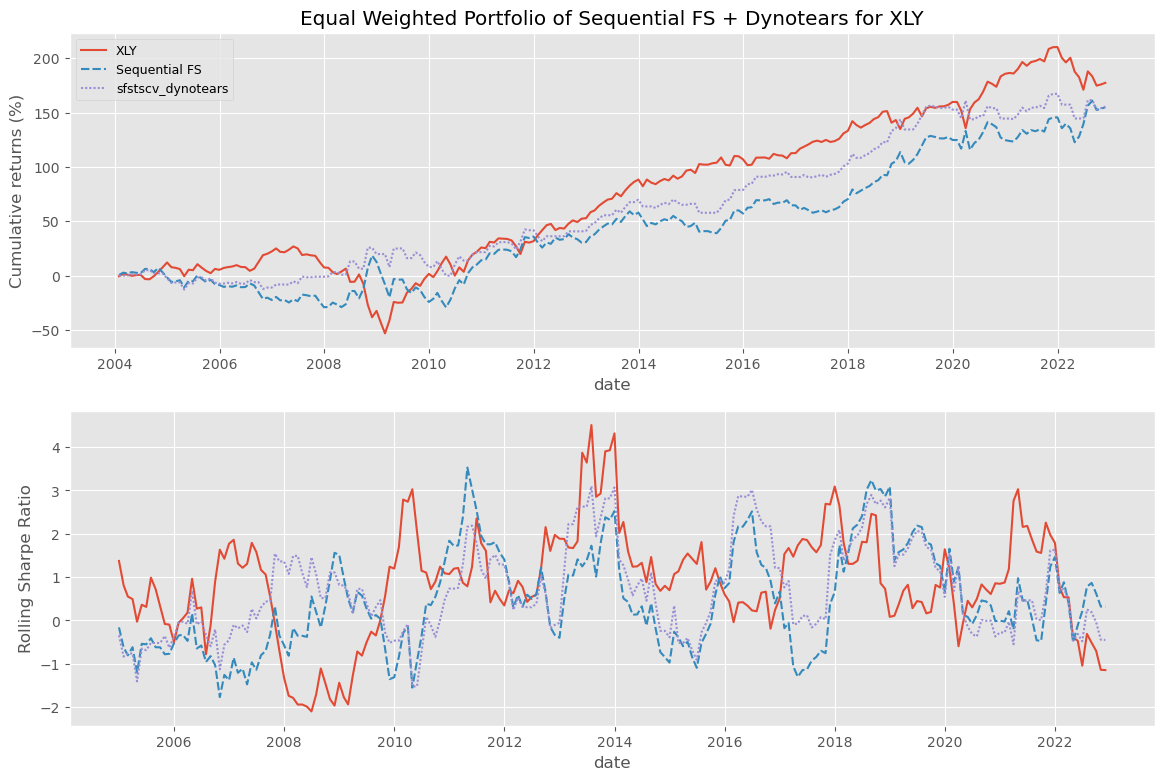

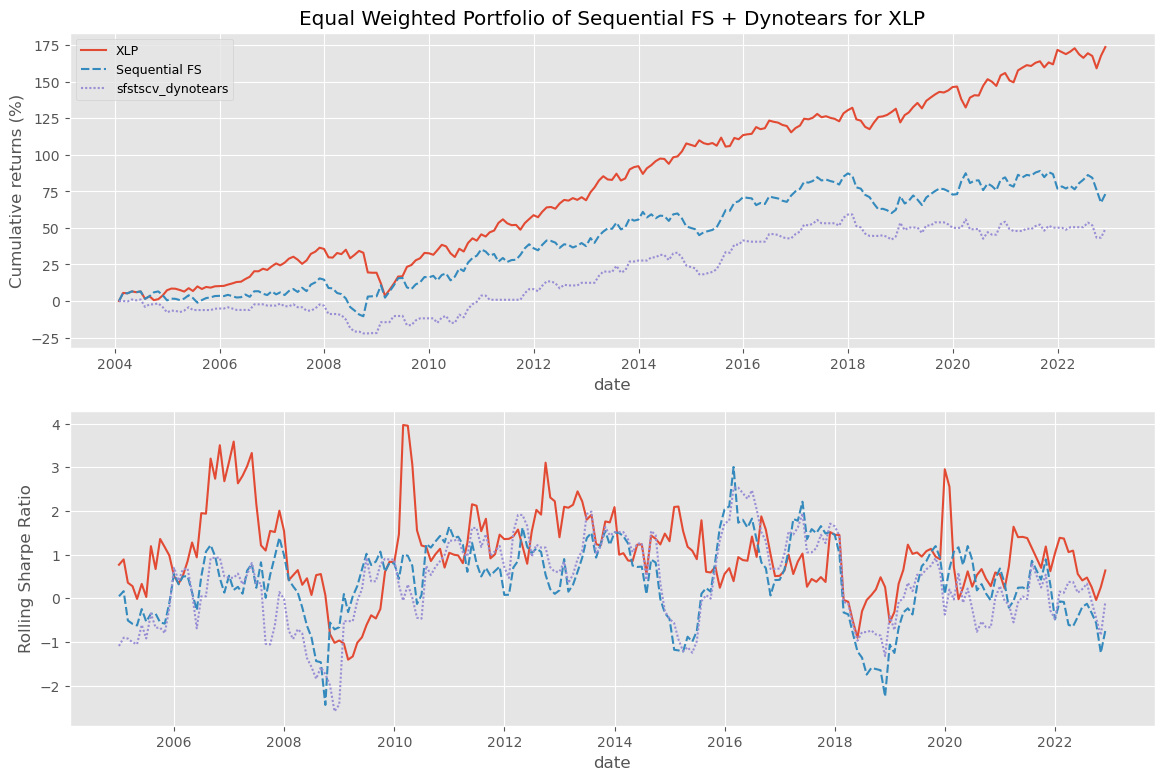

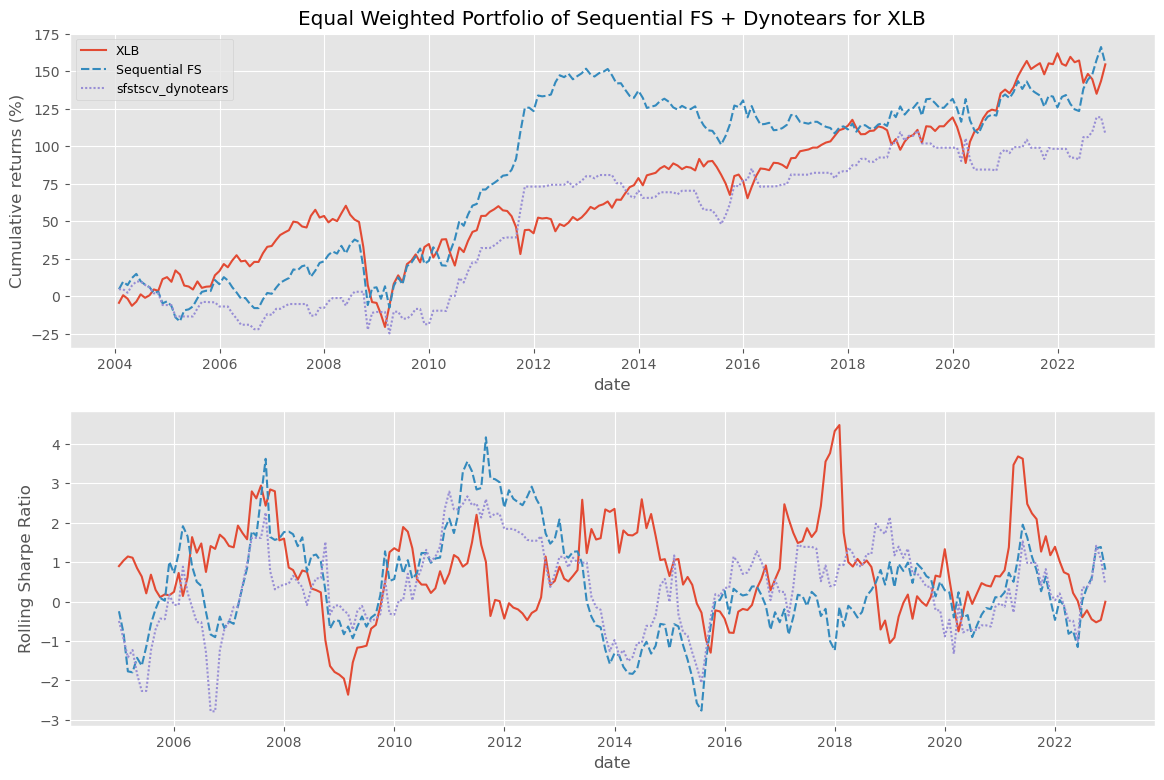

In [30]:
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["sfstscv_dynotears"] = 1/2 * tmp_dfPnl["Sequential FS"] + 1/2 * tmp_dfPnl["Dynotears"]
    # tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "Sequential FS", "sfstscv_dynotears"]].copy()

    new_rolling_sharpe_df = new_dfPnl.apply(lambda x: calculateRollingSharpeRatio(x, window = 12), axis = 0)    

    fig, ax = plt.subplots(2, 1, figsize = (14, 9))
    sns.lineplot(data = new_dfPnl.cumsum() * 100, ax = ax[0])
    ax[0].set_ylabel("Cumulative returns (%)")
    ax[0].set_title(f"Equal Weighted Portfolio of Sequential FS + Dynotears for {target}")

    sns.lineplot(data = new_rolling_sharpe_df, ax = ax[1])
    ax[1].set_ylabel("Rolling Sharpe Ratio")

    ax[0].legend(loc='upper left', prop={'size': 9})
    # ax[1].legend(loc='upper left', prop={'size': 8})
    ax[1].get_legend().remove()

    # export figure
    fig.savefig(os.path.join(results_path, f"{target}_cum_ret_combined.png"))

### Top Sharpe and MaxDD for the Combined Portfolios per ETF

In [31]:
all_measures = []
for target in all_pnl_df["etf"].unique():
    tmp_dfPnl = all_pnl_df[(all_pnl_df["etf"] == target)].drop(["etf"], axis=1)
    tmp_dfPnl = tmp_dfPnl.pivot(index="date", columns="variable")
    tmp_dfPnl.columns = tmp_dfPnl.columns.droplevel()

    tmp_dfPnl["sfstscv_dynotears"] = 1/2 * tmp_dfPnl["Sequential FS"] + 1/2 * tmp_dfPnl["Dynotears"]
    # tmp_dfPnl["lasso_multivariate-granger"] = 1/2 * tmp_dfPnl["lasso"] + 1/2 * tmp_dfPnl["multivariate-granger"]

    new_dfPnl = tmp_dfPnl[[target, "Sequential FS", "sfstscv_dynotears"]].copy()

    i = 0
    for tag, measure in metric_funcs.items():
        measure_values = measure(new_dfPnl)

        if i == 0:
            tmp_measure = pd.DataFrame(measure_values, columns=[tag])
        else:
            tmp_measure[tag] = measure_values
        i += 1
    
    tmp_measure["etf"] = target
    tmp_measure = tmp_measure.reset_index().set_index(["etf", "variable"])

    all_measures.append(tmp_measure)

all_measures_df = pd.concat(all_measures, axis=0)
melt_all_measures_df = all_measures_df.reset_index().rename(columns={"variable": "fs"}).melt(id_vars=["etf", "fs"])

In [32]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2)

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                           
SPY SPY                 8.78       51.81    0.59     2.52  -6.50 -50.78
    Sequential FS       8.65       51.83    0.58     3.44  -7.18 -33.50
XLB Sequential FS       8.19       69.93    0.41     2.10 -15.83 -39.75
    XLB                 8.17       69.93    0.40     1.84  -8.34 -55.44
XLE XLE                 8.96       93.49    0.33     1.44 -19.03 -64.11
    sfstscv_dynotears  -1.51       69.66   -0.07    -0.27 -35.85 -66.82
XLF sfstscv_dynotears   5.62       54.92    0.35     1.95  -6.15 -18.52
    XLF                 4.51       77.80    0.20     0.78 -23.96 -78.63
XLI sfstscv_dynotears   7.79       52.85    0.51     2.96  -5.62 -19.94
    XLI                 8.98       65.05    0.48     1.97  -7.09 -57.15
XLK XLK                11.40       61.70    0.64     3.15  -6.87 -49.45
    sfstscv_dynotears   0.18       44.08    0.01     0.06  -8.63 -57.80
XLP XLP                 9.19       40.72    0.78     3.62  -2.90 -28.13
    Sequential FS       3.87       41.57    0.32     1.81  -5.25 -23.81
XLU XLU                 9.38       49.03    0.66     2.85  -6.59 -38.03
    sfstscv_dynotears   2.95       40.70    0.25     1.07  -6.98 -19.93
XLV XLV                 9.73       47.43    0.71     3.55  -5.05 -35.49
    sfstscv_dynotears   6.69       38.18    0.61     2.92  -4.09 -20.72
XLY XLY                 9.38       63.36    0.51     2.37  -7.25 -55.07
    sfstscv_dynotears   8.22       56.29    0.51     2.27  -5.69 -22.70

In [33]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2)

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                           
SPY SPY                 8.78       51.81    0.59     2.52  -6.50 -50.78
    Sequential FS       8.65       51.83    0.58     3.44  -7.18 -33.50
XLB Sequential FS       8.19       69.93    0.41     2.10 -15.83 -39.75
    XLB                 8.17       69.93    0.40     1.84  -8.34 -55.44
XLE XLE                 8.96       93.49    0.33     1.44 -19.03 -64.11
    sfstscv_dynotears  -1.51       69.66   -0.07    -0.27 -35.85 -66.82
XLF sfstscv_dynotears   5.62       54.92    0.35     1.95  -6.15 -18.52
    XLF                 4.51       77.80    0.20     0.78 -23.96 -78.63
XLI sfstscv_dynotears   7.79       52.85    0.51     2.96  -5.62 -19.94
    XLI                 8.98       65.05    0.48     1.97  -7.09 -57.15
XLK XLK                11.40       61.70    0.64     3.15  -6.87 -49.45
    sfstscv_dynotears   0.18       44.08    0.01     0.06  -8.63 -57.80
XLP XLP                 9.19       40.72    0.78     3.62  -2.90 -28.13
    Sequential FS       3.87       41.57    0.32     1.81  -5.25 -23.81
XLU XLU                 9.38       49.03    0.66     2.85  -6.59 -38.03
    sfstscv_dynotears   2.95       40.70    0.25     1.07  -6.98 -19.93
XLV XLV                 9.73       47.43    0.71     3.55  -5.05 -35.49
    sfstscv_dynotears   6.69       38.18    0.61     2.92  -4.09 -20.72
XLY XLY                 9.38       63.36    0.51     2.37  -7.25 -55.07
    sfstscv_dynotears   8.22       56.29    0.51     2.27  -5.69 -22.70

In [34]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "Sharpe")).reset_index(drop=True).set_index(["etf", "variable"]).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &                   &  E[Rt] &  Volatility &  Sharpe &  Sortino &  AvgDD &  MaxDD \\
etf & variable &        &             &         &          &        &        \\
\midrule
SPY & SPY &   8.78 &       51.81 &    0.59 &     2.52 &  -6.50 & -50.78 \\
    & Sequential FS &   8.65 &       51.83 &    0.58 &     3.44 &  -7.18 & -33.50 \\
XLB & Sequential FS &   8.19 &       69.93 &    0.41 &     2.10 & -15.83 & -39.75 \\
    & XLB &   8.17 &       69.93 &    0.40 &     1.84 &  -8.34 & -55.44 \\
XLE & XLE &   8.96 &       93.49 &    0.33 &     1.44 & -19.03 & -64.11 \\
    & sfstscv\_dynotears &  -1.51 &       69.66 &   -0.07 &    -0.27 & -35.85 & -66.82 \\
XLF & sfstscv\_dynotears &   5.62 &       54.92 &    0.35 &     1.95 &  -6.15 & -18.52 \\
    & XLF &   4.51 &       77.80 &    0.20 &     0.78 & -23.96 & -78.63 \\
XLI & sfstscv\_dynotears &   7.79 &       52.85 &    0.51 &     2.96 &  -5.62 & -19.94 \\
    & XLI &   8.98 &       65.05 &    0.48 &   

In [35]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                           
SPY Sequential FS       8.65       51.83    0.58     3.44  -7.18 -33.50
    sfstscv_dynotears   6.52       42.81    0.53     2.31  -5.26 -34.54
XLB sfstscv_dynotears   5.72       58.86    0.34     1.31 -10.02 -29.26
    Sequential FS       8.19       69.93    0.41     2.10 -15.83 -39.75
XLE XLE                 8.96       93.49    0.33     1.44 -19.03 -64.11
    sfstscv_dynotears  -1.51       69.66   -0.07    -0.27 -35.85 -66.82
XLF sfstscv_dynotears   5.62       54.92    0.35     1.95  -6.15 -18.52
    Sequential FS      -0.55       77.93   -0.02    -0.12 -18.05 -48.32
XLI sfstscv_dynotears   7.79       52.85    0.51     2.96  -5.62 -19.94
    Sequential FS       6.22       65.38    0.33     1.86  -9.98 -42.68
XLK XLK                11.40       61.70    0.64     3.15  -6.87 -49.45
    sfstscv_dynotears   0.18       44.08    0.01     0.06  -8.63 -57.80
XLP sfstscv_dynotears   2.61       32.28    0.28     1.27  -6.27 -20.72
    Sequential FS       3.87       41.57    0.32     1.81  -5.25 -23.81
XLU sfstscv_dynotears   2.95       40.70    0.25     1.07  -6.98 -19.93
    XLU                 9.38       49.03    0.66     2.85  -6.59 -38.03
XLV sfstscv_dynotears   6.69       38.18    0.61     2.92  -4.09 -20.72
    XLV                 9.73       47.43    0.71     3.55  -5.05 -35.49
XLY sfstscv_dynotears   8.22       56.29    0.51     2.27  -5.69 -22.70
    Sequential FS       8.20       63.52    0.45     2.53  -9.85 -37.97

In [36]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                           
SPY Sequential FS       8.65       51.83    0.58     3.44  -7.18 -33.50
    sfstscv_dynotears   6.52       42.81    0.53     2.31  -5.26 -34.54
XLB sfstscv_dynotears   5.72       58.86    0.34     1.31 -10.02 -29.26
    Sequential FS       8.19       69.93    0.41     2.10 -15.83 -39.75
XLE XLE                 8.96       93.49    0.33     1.44 -19.03 -64.11
    sfstscv_dynotears  -1.51       69.66   -0.07    -0.27 -35.85 -66.82
XLF sfstscv_dynotears   5.62       54.92    0.35     1.95  -6.15 -18.52
    Sequential FS      -0.55       77.93   -0.02    -0.12 -18.05 -48.32
XLI sfstscv_dynotears   7.79       52.85    0.51     2.96  -5.62 -19.94
    Sequential FS       6.22       65.38    0.33     1.86  -9.98 -42.68
XLK XLK                11.40       61.70    0.64     3.15  -6.87 -49.45
    sfstscv_dynotears   0.18       44.08    0.01     0.06  -8.63 -57.80
XLP sfstscv_dynotears   2.61       32.28    0.28     1.27  -6.27 -20.72
    Sequential FS       3.87       41.57    0.32     1.81  -5.25 -23.81
XLU sfstscv_dynotears   2.95       40.70    0.25     1.07  -6.98 -19.93
    XLU                 9.38       49.03    0.66     2.85  -6.59 -38.03
XLV sfstscv_dynotears   6.69       38.18    0.61     2.92  -4.09 -20.72
    XLV                 9.73       47.43    0.71     3.55  -5.05 -35.49
XLY sfstscv_dynotears   8.22       56.29    0.51     2.27  -5.69 -22.70
    Sequential FS       8.20       63.52    0.45     2.53  -9.85 -37.97

In [37]:
print(all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "MaxDD")).reset_index(drop=True).set_index(["etf", "variable"]).round(2).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
    &               &  E[Rt] &  Volatility &  Sharpe &  Sortino &  AvgDD &  MaxDD \\
etf & variable &        &             &         &          &        &        \\
\midrule
SPY & Sequential FS &   8.65 &       51.83 &    0.58 &     3.44 &  -7.18 & -33.50 \\
    & sfstscv\_dynotears &   6.52 &       42.81 &    0.53 &     2.31 &  -5.26 & -34.54 \\
XLB & sfstscv\_dynotears &   5.72 &       58.86 &    0.34 &     1.31 & -10.02 & -29.26 \\
    & Sequential FS &   8.19 &       69.93 &    0.41 &     2.10 & -15.83 & -39.75 \\
XLE & XLE &   8.96 &       93.49 &    0.33 &     1.44 & -19.03 & -64.11 \\
    & sfstscv\_dynotears &  -1.51 &       69.66 &   -0.07 &    -0.27 & -35.85 & -66.82 \\
XLF & sfstscv\_dynotears &   5.62 &       54.92 &    0.35 &     1.95 &  -6.15 & -18.52 \\
    & Sequential FS &  -0.55 &       77.93 &   -0.02 &    -0.12 & -18.05 & -48.32 \\
XLI & sfstscv\_dynotears &   7.79 &       52.85 &    0.51 &     2.96 &  -5.62 & -19.94 \\
    & Seque

In [38]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "AvgDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                           
SPY sfstscv_dynotears   6.52       42.81    0.53     2.31  -5.26 -34.54
    SPY                 8.78       51.81    0.59     2.52  -6.50 -50.78
XLB XLB                 8.17       69.93    0.40     1.84  -8.34 -55.44
    sfstscv_dynotears   5.72       58.86    0.34     1.31 -10.02 -29.26
XLE XLE                 8.96       93.49    0.33     1.44 -19.03 -64.11
    sfstscv_dynotears  -1.51       69.66   -0.07    -0.27 -35.85 -66.82
XLF sfstscv_dynotears   5.62       54.92    0.35     1.95  -6.15 -18.52
    Sequential FS      -0.55       77.93   -0.02    -0.12 -18.05 -48.32
XLI sfstscv_dynotears   7.79       52.85    0.51     2.96  -5.62 -19.94
    XLI                 8.98       65.05    0.48     1.97  -7.09 -57.15
XLK XLK                11.40       61.70    0.64     3.15  -6.87 -49.45
    sfstscv_dynotears   0.18       44.08    0.01     0.06  -8.63 -57.80
XLP XLP                 9.19       40.72    0.78     3.62  -2.90 -28.13
    Sequential FS       3.87       41.57    0.32     1.81  -5.25 -23.81
XLU XLU                 9.38       49.03    0.66     2.85  -6.59 -38.03
    sfstscv_dynotears   2.95       40.70    0.25     1.07  -6.98 -19.93
XLV sfstscv_dynotears   6.69       38.18    0.61     2.92  -4.09 -20.72
    XLV                 9.73       47.43    0.71     3.55  -5.05 -35.49
XLY sfstscv_dynotears   8.22       56.29    0.51     2.27  -5.69 -22.70
    XLY                 9.38       63.36    0.51     2.37  -7.25 -55.07

In [39]:
all_measures_df.reset_index().groupby("etf").apply(lambda x: x.nlargest(2, "AvgDD")).reset_index(drop=True).round(2).set_index(["etf", "variable"])

E[Rt]  Volatility  Sharpe  Sortino  AvgDD  MaxDD
etf variable                                                           
SPY sfstscv_dynotears   6.52       42.81    0.53     2.31  -5.26 -34.54
    SPY                 8.78       51.81    0.59     2.52  -6.50 -50.78
XLB XLB                 8.17       69.93    0.40     1.84  -8.34 -55.44
    sfstscv_dynotears   5.72       58.86    0.34     1.31 -10.02 -29.26
XLE XLE                 8.96       93.49    0.33     1.44 -19.03 -64.11
    sfstscv_dynotears  -1.51       69.66   -0.07    -0.27 -35.85 -66.82
XLF sfstscv_dynotears   5.62       54.92    0.35     1.95  -6.15 -18.52
    Sequential FS      -0.55       77.93   -0.02    -0.12 -18.05 -48.32
XLI sfstscv_dynotears   7.79       52.85    0.51     2.96  -5.62 -19.94
    XLI                 8.98       65.05    0.48     1.97  -7.09 -57.15
XLK XLK                11.40       61.70    0.64     3.15  -6.87 -49.45
    sfstscv_dynotears   0.18       44.08    0.01     0.06  -8.63 -57.80
XLP XLP                 9.19       40.72    0.78     3.62  -2.90 -28.13
    Sequential FS       3.87       41.57    0.32     1.81  -5.25 -23.81
XLU XLU                 9.38       49.03    0.66     2.85  -6.59 -38.03
    sfstscv_dynotears   2.95       40.70    0.25     1.07  -6.98 -19.93
XLV sfstscv_dynotears   6.69       38.18    0.61     2.92  -4.09 -20.72
    XLV                 9.73       47.43    0.71     3.55  -5.05 -35.49
XLY sfstscv_dynotears   8.22       56.29    0.51     2.27  -5.69 -22.70
    XLY                 9.38       63.36    0.51     2.37  -7.25 -55.07